In [2]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 16*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh

from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2
from lidar_nerf_utils import *

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-07-08 20:34:18.552713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 20:34:19.247209: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 20:34:20.513894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-07-08 20:34:20.514038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-08 20:34:23.520565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 20:34:23.522560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-08 20:34:23.522958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-08 20:34:23.523619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [8]:
#load raw point cloud data from Newer College Dataset

#NEWER COLLEGE
idx = 7700 #7800 #1500 
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention used in VICET

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
## purple -> green
color = 255*np.linspace(0,1,len(pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
# disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
# print(len(pc1) / 128)
disp.append(Points(pc1, c='red',  r = 3.5, alpha =0.5))

#remove NaNs
# pc1[pc1[:,0]>64] = 100
# pc1[pc1[:,0]<-64] = 100
# pc1 = np.nan_to_num(pc1, nan=0.0)

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to Depth Image

(64, 1024)


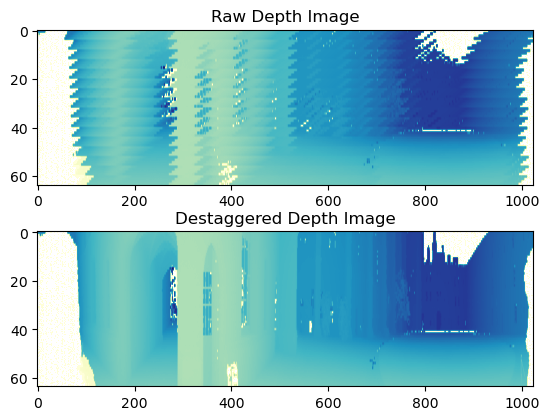

In [9]:
# %matplotlib notebook
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
pcs = np.reshape(pc1_spherical, [-1,64,3])
pcs = np.flip(pcs, axis = 1)
raw_data = pcs[:,:,0].T

# print(np.shape(data))

data = np.zeros([64, 1024])
for i in range(np.shape(data)[0]//4):
    #shift left
#     data[4*i,:-18] = raw_data[4*i,18:]
#     data[4*i+1,:-12] = raw_data[4*i+1,12:]
#     data[4*i+2,:-6] = raw_data[4*i+2,6:]
#     data[4*i+3,:] = raw_data[4*i+3,:]
    #shift right
    data[4*i,:] = raw_data[4*i,:]
    data[4*i+1,6:] = raw_data[4*i+1,:-6]
    data[4*i+2,12:] = raw_data[4*i+2,:-12]
    data[4*i+3,18:] = raw_data[4*i+3,:-18]
#     #keep centered-- avoids needing to fill in gaps
#     data[4*i,1:-8] = raw_data[4*i,9:]
#     data[4*i+1,1:-2] = raw_data[4*i+1,3:]
#     data[4*i+2,4:] = raw_data[4*i+2,:-4]
#     data[4*i+3,10:] = raw_data[4*i+3,:-10]
    
# # data = np.flip(data, axis =1)
# #try shifting horizontally
# n = 16
# data = np.hstack((data[:, n:], data[:, :n]))

fig, ax = p.subplots(2,1)
ax[0].set_title("Raw Depth Image")
ax[0].imshow(raw_data, cmap = "YlGnBu", norm='log')
ax[0].set_aspect(5)
ax[1].set_title("Destaggered Depth Image")
ax[1].imshow(data, cmap = "YlGnBu", norm='log')
ax[1].set_aspect(5)
print(np.shape(data))


# Reproject 2D Depth image back to 3D point cloud

#### IMPORTANT: look into pixel_shift_by_row parameter from OUSTER
https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts

(57364, 3)
15.59400113154328
-17.74300136291319
(68,)
0.6230001213315859 deg between vertical samples


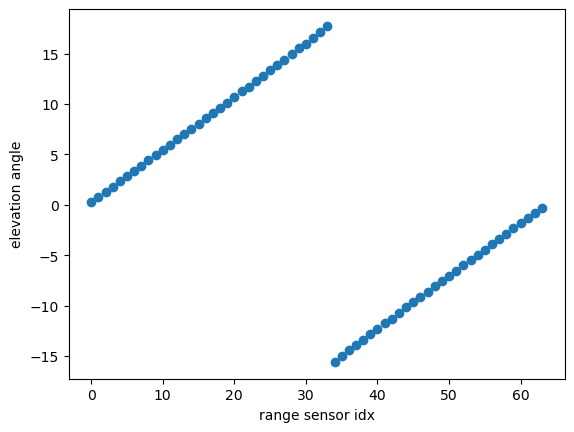

In [10]:
#get max and min phi values of sensor by looking at actual point xyz data
pc1_spherical = pc1_spherical[~np.isnan(pc1_spherical).any(axis=1)]
print(np.shape(pc1_spherical))
# print(np.rad2deg(pc1_spherical[:,2]))
# print(90-np.rad2deg(np.max(pc1_spherical[:,2]))) #-15.59
# print(90-np.rad2deg(np.min(pc1_spherical[:,2]))) #17.74
print(np.rad2deg(np.max(pc1_spherical[:,2]))-90) #15.59
print(np.rad2deg(np.min(pc1_spherical[:,2]))-90) #-17.74

#look at point elevations
fig, ax = p.subplots();
print(np.shape(90-np.rad2deg((pc1_spherical[1024:1092,2]))))
ax.scatter(np.linspace(0,63,64), 90-np.rad2deg((pc1_spherical[4096:4160,2])))
ax.set_xlabel("range sensor idx")
ax.set_ylabel("elevation angle")
test = np.diff(90-np.rad2deg((pc1_spherical[:64,2])))
print(test[0], "deg between vertical samples")

In [11]:
#OS1 LiDAR Intrinsics
#as specified in datasheet
# phimin = np.deg2rad(-16.6) #supposed to be this
# phimax = np.deg2rad(16.6)
#angles required to reproduce observed point clouds
# phimin = np.deg2rad(-16) 
# phimax = np.deg2rad(17.75)
#test
phimax = np.deg2rad(17.74)
phimin = np.deg2rad(-15.59)
depth_img  = data.T

new_point_cloud_spherical = np.zeros([np.shape(pcs)[0]*np.shape(pcs)[1],3])
pc1_spherical = new_point_cloud_spherical

count = 0
for w in range(np.shape(depth_img)[0]):
    for h in range(np.shape(depth_img)[1]):
        new_point_cloud_spherical[count,0] = depth_img[w,h] #radius
        new_point_cloud_spherical[count,1] = 2*np.pi*(w/np.shape(depth_img)[0]) #theta
#         new_point_cloud_spherical[count,1] = (1023/1024) * 2*np.pi*(w/np.shape(depth_img)[0]) #test
#         new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth_img)[1]) #phi
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(np.shape(depth_img)[1] - 1)) #BETTER
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

#shape image to have same angular field of view in width and height
vert_fov = np.rad2deg(phimax-phimin)
# print(vert_fov)
# vert_fov/360
# print((vert_fov/360)*np.shape(pcs)[0])

In [12]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

color = 255*np.linspace(0,1,len(new_point_cloud_cart)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(new_point_cloud_cart, c=cname,  r = 3.5, alpha =0.5))
# disp.append(Points(new_point_cloud_cart[::32], c='red',  r = 3.5, alpha =0.8))
# disp.append(Points(new_point_cloud_cart[::4], c='blue',  r = 5., alpha =0.125))

disp.append(Points(pc1, c = 'blue', r = 3.5, alpha = 0.5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [13]:
#TEST depth-rendering
z = np.linspace(0,10)
print(z)
alpha = 1. - tf.exp(-z)
print(alpha)

[ 0.          0.20408163  0.40816327  0.6122449   0.81632653  1.02040816
  1.2244898   1.42857143  1.63265306  1.83673469  2.04081633  2.24489796
  2.44897959  2.65306122  2.85714286  3.06122449  3.26530612  3.46938776
  3.67346939  3.87755102  4.08163265  4.28571429  4.48979592  4.69387755
  4.89795918  5.10204082  5.30612245  5.51020408  5.71428571  5.91836735
  6.12244898  6.32653061  6.53061224  6.73469388  6.93877551  7.14285714
  7.34693878  7.55102041  7.75510204  7.95918367  8.16326531  8.36734694
  8.57142857  8.7755102   8.97959184  9.18367347  9.3877551   9.59183673
  9.79591837 10.        ]
tf.Tensor(
[0.         0.18460419 0.33512968 0.45786753 0.55794746 0.63955221
 0.70609239 0.76034896 0.80458955 0.84066314 0.87007739 0.89406165
 0.91361831 0.92956474 0.94256738 0.95316968 0.96181476 0.96886391
 0.97461176 0.97929854 0.98312012 0.98623621 0.98877707 0.99084887
 0.9925382  0.99391568 0.99503887 0.99595472 0.99670149 0.99731041
 0.99780692 0.99821177 0.99854189 0.99881106

In [14]:
# import matplotlib.pyplot as plt
# print(plt.get_backend())

## Load ground truth poses (map frame) and convert to NeRF LH Coordinate System

In [4]:
from os import listdir

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(np.shape(gt))
# print(gt[20,:])

scan_dir = dir_name + experiment_name + "raw_format/ouster_zip_files/ouster_scan-007/ouster_scan/"
list_of_all_scans = sorted(listdir(scan_dir))

#plot ground truth trajectory
fig, ax = p.subplots()
ax.set_aspect('equal')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot(gt[:,2], gt[:,3], label = "ground truth")

#superimpose trajectory from <short_experiment_01>
# first_timestamp = int(list_of_all_scans[0][6:16])
# last_timestamp = int(list_of_all_scans[-1][6:16]) #scrape timestamp from name of velodyne .pcl file
# first_idx = np.argwhere(gt[:,0] == first_timestamp)[0][0]
# last_idx = np.argwhere(gt[:,0] == last_timestamp)[0][0]
first_idx = 7650#7700 #1500 #1450 #700
last_idx = 8700 #2100 #1950 #1000

ax.plot(gt[first_idx:last_idx,2], gt[first_idx:last_idx,3], 'r', lw = 10, alpha = 0.3, label = 'training region')
ax.legend(loc = 'best')
ax.set_ylim([-150,30])

FileNotFoundError: /media/derm/06EF-127D4/Newer College Dataset/01_short_experiment-20230331T172433Z-009/01_short_experiment/ground_truth/registered_poses.csv not found.

In [ ]:
from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 50 #20 
n_rots = 8 #8 
#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
#just for debug
# phimin = np.deg2rad(-6) 
# phimax = np.deg2rad(27.75)
# phimin = -0.53529248 #rad
# phimax = 0.18622663 #rad
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots,4,4])
images = np.ones([n_images*n_rots, 64, 64, 2]) #depth image and raydrop

#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
# focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #not used here
H, W = images.shape[1:3]
print(H, W)

for i in range(n_images):
    #load point cloud
    idx = i*10 + 600 #1450 #700    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    #convert to depth image
    pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1)

#     print(np.shape(data))
#     print(np.shape(pc1_spherical))

    for j in range(n_rots):
        
        #get cropped depth image ~~~~~~~~~~~~~~~~~~~~
#         pcs = np.flip(data, axis = 1) #flip vertical
#         pcs = np.flip(pcs, axis = 0) #flip horizontal to look at first clockwise patch of scan sweep 
#         pcs = pcs.T
        pcs = data.T
        
        #resize image to 64x64
        image_width = int((vert_fov/360)*np.shape(pcs)[0])        
#         pcs = pcs[j*image_width:(j+1)*image_width,:].T #SQUARE
        pcs = pcs[(j+1)*image_width:(j+2)*image_width,:].T #SQUARE-- skip beginning of frame (blocked by human)
#         pcs = pcs[(j*image_width//32):((j+1)*image_width//32),:,0].T #32nds
        pcs = cv2.resize(pcs, (64, 64), cv2.INTER_NEAREST) #keep square
        #TEST
#         pcs = np.flip(pcs, axis =1)
    
        #preserve aspect ratio and focal length but just take middle
#         pcs = pcs[:,31:33] #uncomment for 32nds
        images[j+(i*n_rots),:,:,0] = pcs #save depth information to first channel
        a = np.argwhere(pcs == 0)
        #TODO: why do some distant windows register as being close (but not non-returns)??
        images[j+(i*n_rots),a[:,0],a[:,1],1] = 0 #save raydrop mask to 2nd channel
        
        #get transformation matrix ~~~~~~~~~~~~~~~~~~
        rotm = np.eye(4)
        rotm[1,3] = -gt[idx,2] #x
        rotm[2,3] = gt[idx,3] #y
        rotm[0,3] = -gt[idx,4] #z
        rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 

# #         #orient yellow (-z) pointing forward
        fix1 = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix()
        fix2 = R.from_euler('xyz', [np.pi/2,0,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ fix1 @ fix2

        #unreliable?
        temp = R.from_matrix(rotm[:3,:3]).as_euler('zxy')
        rotm[:3,:3] = R.from_euler('xyz', [temp[0], temp[1], -temp[2]]).as_matrix()
                
        #account for image crop in rotation
        #swapping sign convention from what was used in synthetic data(?) ...+j*(phimax-phimin)
#         crop_angle = 0 #DEBUG ONLY
#         crop_angle = -(phimax-phimin)/2 + j*(phimax-phimin) #square
        crop_angle = -(phimax-phimin)/2 + (j+1)*(phimax-phimin) #square-- but skip beginning of frame
        #         crop_angle = -(phimax-phimin)/64 - j*(phimax-phimin)/32 #2-pixels wide
        
        #account for the fact that sensor points back and to the left
        crop_angle -= np.pi/4 
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix() #looks better
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #was this
#         sensor_elevation_zero_rotm = R.from_euler('xyz', [0,(phimin+phimax)/2,0]).as_matrix() #TODO: not sure if rot about y or z
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm

        #flip x and z axis
#         rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 
#         rotm[0,-1], rotm[1,-1] = rotm[1,-1], rotm[0,-1]  #test

# #         # flip sign of axis
#         rotm[0:3,2] *= -1 #was this
#         rotm[0:3,1] *= -1 #was this
#         rotm[0:3,0] *= -1 #test
#         rotm = rotm[[1,0,2,3],:] #was this
#         rotm = rotm[[2,0,1,3],:]
#         rotm[2,:] *= -1 # flip whole world upside down
#         #translate all frames above xy plane
        rotm[2,-1] += 45 
        
        #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
        rotm[:3,-1] *= 0.05
        images[j+(i*n_rots),:,:,0] *= 0.05
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        poses[j+(i*n_rots)] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)
        
# test on one only
testimg, testpose = images[(n_images*n_rots)-1], poses[(n_images*n_rots)-1]
images = images[:((n_images*n_rots)-1),...,:3]
poses = poses[:((n_images*n_rots)-1)]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

In [ ]:
# %matplotlib notebook
fig, ax = p.subplots(2,5)
ax[0,0].set_title("depth image patches for training")

# ax[0,0].imshow(images[0,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[1,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[2,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[3,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[4,:,:,0])#, vmin=0, vmax=64)

ax[0,0].imshow(images[-4,:,:,0])#, vmin=0, vmax=64)
ax[0,1].imshow(images[-3,:,:,0])#, vmin=0, vmax=64)
ax[0,2].imshow(images[-2,:,:,0])#, vmin=0, vmax=64)
ax[0,3].imshow(images[-1,:,:,0])#, vmin=0, vmax=64)
ax[0,4].imshow(testimg[:,:,0])#, vmin=0, vmax=64)

ax[1,0].set_title("ray drop masks")
ax[1,0].imshow(images[-4,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,1].imshow(images[-3,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,2].imshow(images[-2,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,3].imshow(images[-1,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,4].imshow(testimg[:,:,1],cmap="gray", vmin=0,vmax=1)

# Debug: draw frames

In [ ]:
#Raw frames, in Newer College RHCS convention
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

# new_point_cloud_spherical = np.zeros([np.shape(images)[1]*np.shape(images)[2],3])

for i in range(30):
    idx = i*20 + 600    
    
    rotm = np.eye(4)
    rotm[0,3] = gt[idx,2] #x
    rotm[1,3] = gt[idx,3] #y
    rotm[2,3] = gt[idx,4] #z
    rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 
    
    #draw frames for each sub-scan 
    alph = 1-(i/30)
    #forward view direction (-z in NeRF c2w convention)
    headings = rotm[:3,:3] @ np.array([0,0,-1])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
    headings = rotm[:3,:3] @ np.array([1,0,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = rotm[:3,:3] @ np.array([0,1,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = rotm[:3,:3] @ np.array([0,0,1])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "blue", alpha = alph))

disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Actual Ground Truth Path (Newer College Frame)")
ViewInteractiveWidget(plt.window)

(64, 456, 2)
together (64, 456, 2)
mask (64, 456, 1)
(3, 64, 8, 2)
(64, 8, 2)
(8, 64)


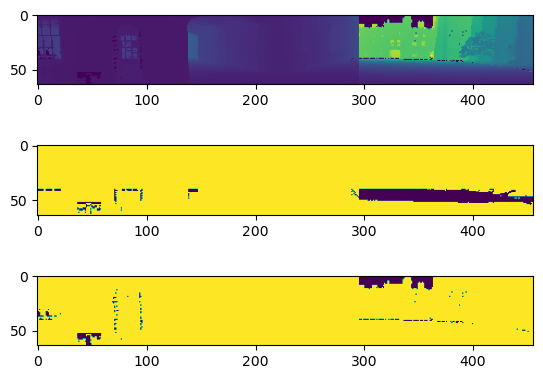

In [405]:
#DEBUG-- find appropriate cutoff threshold for "structural regularization" loss
# thresh_horiz = 0.025
# thresh_vert = 0.025
thresh_horiz = 1
thresh_vert = 0.005
aspect = 1
idx = 1500


testy = images[idx,:,:]
for i in range(56):
    testy = np.append(testy, images[idx + i,:,:], axis = 1)

print(np.shape(testy))

fig, ax = p.subplots(3)
# ax[0].imshow(data, aspect = 5)
ax[0].imshow(testy[:,:,0], aspect = aspect)

mask = np.ones(np.shape(testy))
vertical_grad_target = np.gradient(testy)[0][:,:,0]
# vertical_grad_target = np.gradient(vertical_grad_target)[0] #test for double gradient 
vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh_vert)
mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 0

horizontal_grad_target = np.gradient(testy)[1][:,:,0]
# horizontal_grad_target = np.gradient(horizontal_grad_target)[1] #test for double gradient 
horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh_horiz)
mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 0

# print(np.shape(mask))
save_non_ground = tf.zeros_like(mask).numpy()
save_non_ground[:40,:,:] = 1
save_non_groud = tf.convert_to_tensor(save_non_ground)
together = tf.concat([save_non_groud[:,:,:1], mask[:,:,:1]], axis = -1)
mask = tf.math.reduce_max(together, axis = -1)[:,:,None]
print("together", np.shape(together))
print("mask", np.shape(mask))

# print(np.shape(vertical_grad_target))
# print(np.shape(mask))
print(np.shape(np.gradient(images[idx,:,:])))
print(np.shape(images[idx,:,:]))
print(np.shape(depth))

ax[1].imshow(mask[:,:,0], aspect=aspect)
ax[2].imshow(testy[:,:,1], aspect = aspect)

In [ ]:
##DEBUG get_rays()
# H = 64 
# W = 1024
H = 8 
W = 8

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 8 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots
vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
print("vertical bins", np.rad2deg(vertical_bins), "\n")

i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
# print(i)
# print(j)
phimin = np.deg2rad(-15.593)
phimax = np.deg2rad(17.743)
print("phimin", np.rad2deg(phimin))
print("phimax", np.rad2deg(phimax))

# test = (phimax + phimin)/2 + ((-j+((H-1)/2))/(H-1))*(phimax-phimin) -np.pi/2

for img_i in range(9):
    #old-- was using for spherical projection(?)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
#     phimin_patch = vertical_bins[img_i%(n_vert_patches-1)] 
#     phimax_patch = vertical_bins[img_i%(n_vert_patches-1) + 1]
#     # send bins from top to bottom --- using for cylindrical projections
#     phimin_patch = vertical_bins[len(vertical_bins) -1 - (img_i%n_vert_patches+1)] 
#     phimax_patch = vertical_bins[len(vertical_bins) -1 - (img_i%n_vert_patches)]

    print("\n phimin_patch", np.rad2deg(phimin_patch), " phimax_patch", np.rad2deg(phimax_patch))
    
    #thought this was better yesterday, looks like I was still be double counting at borders though
#     test = (phimax_patch + phimin_patch)/2 + ((-j+((H-1)/2))/(H-1))*(phimax_patch-phimin_patch) -np.pi/2 
    
#     test = (phimax_patch + phimin_patch)/2 + ((-j+((H)/2))/(H))*(phimax_patch-phimin_patch) -np.pi/2
    test = (phimax_patch + phimin_patch)/2 - ((-j+((H)/2))/(H))*(phimax_patch-phimin_patch) -np.pi/2

    print(np.rad2deg(test[:,0]) + 90)
#     print(np.rad2deg(test) + 90)

# print(90+np.rad2deg(test[:,0]))

# print(np.rad2deg(phimax_patch), np.rad2deg(phimin_patch))

# print((17.75 + 15.47)/64)

In [ ]:
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots
i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')

phivals = np.linspace(phimin, phimax, 64)
# print("all phivals: ", np.rad2deg(phivals), "\n")

for img_i in range(9):
    print(img_i)
#     print("old", (img_i%(n_vert_patches))*(64//n_vert_patches), ((img_i+1)%(n_vert_patches))*(64//n_vert_patches)-1)    

#     print("idx test first", 64-(img_i%(n_vert_patches))*(64//n_vert_patches))
#     print("idx test second", 64-((img_i+1)%(n_vert_patches))*(64//n_vert_patches)-1)    
    
    #does correct thing but patches are flipped during training(?)
    phimin_patch = phivals[(img_i%(n_vert_patches))*(64//n_vert_patches)]
    phimax_patch = phivals[((img_i+1)%(n_vert_patches))*(64//n_vert_patches)-1]

#     #send patches top->bottom
#     idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
#     idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
# #     print("test ", idx_first, idx_second)
#     phimin_patch = phivals[idx_first]
#     phimax_patch = phivals[idx_second]    
    
    print(" phimin_patch ", np.rad2deg(phimin_patch), "phimax_patch ", np.rad2deg(phimax_patch))
    
    test = (phimax_patch + phimin_patch)/2 - ((-j+((H-1)/2))/(H-1))*(phimax_patch-phimin_patch) -np.pi/2 #correct
#     test = (phimax_patch + phimin_patch)/2 + ((-j+((H-1)/2))/(H-1))*(phimax_patch-phimin_patch) -np.pi/2 #flips order
    print(np.rad2deg(test[:,0]) + 90, "\n")
    
    #brokent up by channel
#     print(np.rad2deg(phivals[int(img_i*(64//n_vert_patches)):int((img_i+1)*(64//n_vert_patches))]))

In [ ]:
i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
W = 8

print(i[0])

old = (i - (W//2))  /(W) * (2*np.pi/(1024//W))
print(old[0])
print((old[0,0] - old[0,-1]).numpy())

# new = (i - ((W-1)/2))  /(W-1) * (2*np.pi/(1024//(W-1)))
new = (i - ((W-1)/2))  /(W) * (2*np.pi/(1024//(W)))
print("\n", new[0])
print((new[0,0] - new[0,-1]).numpy())

## Train Network

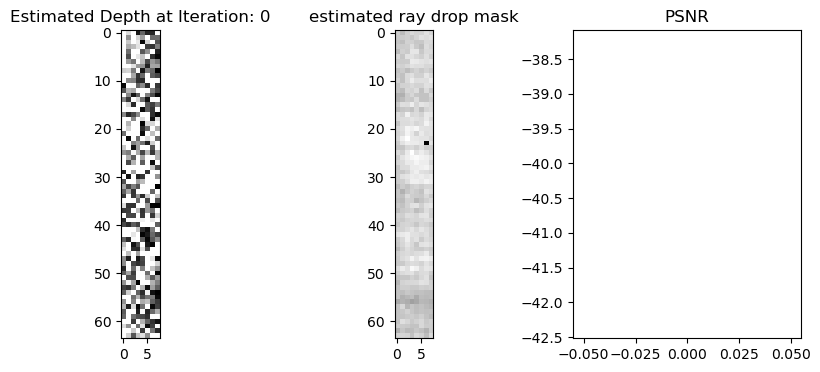

KeyboardInterrupt: 

In [345]:
from lidar_nerf_utils import *
from numpy.lib.stride_tricks import sliding_window_view

model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
# optimizer = tf.keras.optimizers.Adam(5e-5) #anneal to this (LiDAR NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-5) #<-- pick up from here with PDFv7
# optimizer = tf.keras.optimizers.Adam(5e-6) #anneal to this (Mip-NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-6) #TEST

N_samples = 128 #128
near=0.
far=1.
N_iters = 5_000_000
psnrs = []
iternums = []
i_plot = 64
accumulate_gradients_steps = 4 #32
runfine = True
# runfine = False

#IMPORTANT-- this needs to match values used when setting up training data 
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

phimin = np.deg2rad(-15.594) #observed in raw data 
phimax = np.deg2rad(17.743) #observed in raw data
# phimin = np.deg2rad(-17.743) #flipped-- used for best synthetic-- WAS using this for best real data
# phimax = np.deg2rad(15.594) #flipped
#need to do this when actual data was [-25,5] according to print(90-np.rad2deg(np.max(pc1_spherical[:,2])))
# phimin = np.deg2rad(-5) 
# phimax = np.deg2rad(25) 

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

gradients = [tf.zeros_like(var) for var in model.trainable_variables]
accumulated_loss = 0.0

for i in range(N_iters+1):
#     print(i)
    img_i = np.random.randint(images.shape[0])
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]

#     #bottom to top
#     phimin_patch = phivals[(img_i%(n_vert_patches))*(64//n_vert_patches)]
#     phimax_patch = phivals[((img_i+1)%(n_vert_patches))*(64//n_vert_patches)-1]
    #top to bottom -- used this to make v10 (best so far)
    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]     #was this (wrong??)
    phimax_patch = phivals[idx_second]    #was this (wrong??)
#     phimin_patch = phivals[idx_second]     #test
#     phimax_patch = phivals[idx_first]    #test

    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
#         depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
#         depth, acc, ray_drop, weights, d1, d2 = render_rays(model, rays_o, rays_d,  z_vals)
        # depth, ray_drop, CDF = render_rays(model, rays_o, rays_d,  z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
#         print("\n depth:", np.shape(depth))
#         print("acc:", np.shape(acc))
#         print("ray_drop:", np.shape(ray_drop))
#         print("weights:", np.shape(weights))

        depth = depth[:,:,None]
#         print("old", np.shape(depth))
        ray_drop = ray_drop[:,:,None]
        # loss_coarse = calculate_loss(depth, ray_drop, target, target_drop_mask) #ignore similarity of d1&d2 and CDF
        # print(np.shape(z_vals[...,:]), np.shape(target))
        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        loss_coarse = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF) #punish similar depth returns
        loss = loss_coarse

        # #DEBUG---- calculate loss directly from CDF ~~~~~~~~
        # gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        # gtCDF = tf.cast(gtCDF, tf.float32)
        # # print("\n CDF: ", np.shape(CDF))
        # # print("gtCDF: ", np.shape(gtCDF))
        # # print("z_vals[:,:,:,0]", np.shape(z_vals[:,:,:,0]))
        # # print("target", np.shape(target))
        # loss = tf.abs(CDF - gtCDF)
        # loss_coarse = tf.reduce_sum(loss)
        # loss = loss_coarse
        # # loss = loss*0.001
        # # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        if runfine:
            # run fine network ~~~~~~~~~~~~~~~~~~
            #pad weights with zeros
#             fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#             rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#             #use additional axis to calculate all at once
#             fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#             rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
            #TEST-- slightly wider blur-pool
            fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
            rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
            fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
            rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)

    
            #blur-pool as vectorized operation
            test2 = (fwd_test + rev_test) /2 #blur
    #         test2 += 1/N_samples #shift up slightly
            test2 += 1/(3*N_samples) #shift up slightly
            test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
            
            cum_hist_vals = np.cumsum(test2, axis = -1)
            randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
            cum_hist_vals_flat = cum_hist_vals.flatten()
    
            #modify cum_hist_vals so it is monotonically increasing (needed for interp func to work)
            step_corr = np.linspace(0,W*H-1,W*H)
            step_corr = np.tile(step_corr,(N_samples,1)).T
            step_corr = np.reshape(step_corr, [1,-1])[0,:]
            cum_hist_vals_flat+= step_corr
    
            linear_spaced = np.linspace(near, H*W, N_samples*H*W)
            ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
            ans -= step_corr
            ans *= far #scale back to max value
            ans = np.abs(ans)
            z_vals = np.reshape(ans, [H,W,N_samples,1])
            
            gtCDF = z_vals[:,:,:,0] > target[:,:,:]
            gtCDF = tf.cast(gtCDF, tf.float32)
            
            #run actual 2nd pass through same network
#             depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
#             depth, acc, ray_drop, weights, d1, d2 = render_rays(model, rays_o, rays_d,  z_vals)
            # depth, ray_drop = render_rays(model, rays_o, rays_d,  z_vals)
            depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
            depth = depth[:,:,None]
            depth = tf.cast(depth, tf.float32) #why do I have to cast this here???
            ray_drop = ray_drop[:,:,None]
            
            # loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask)
            loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
            loss = 0.1*loss_coarse + 0.9*loss_fine 
#             loss = loss_fine #test
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        
        #NEW--prevent NaN gradients from crashing training routine(?) -- needed for monotonically increasing outputs?
        current_gradients = tape.gradient(loss, model.trainable_variables)
        current_gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(current_gradients, model.trainable_variables)]
        gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]        

        # #OLD-- not working with CDF stuff
        # current_gradients = tape.gradient(loss, model.trainable_variables)
        # gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]    
        
        accumulated_loss += loss
    
    if i%accumulate_gradients_steps==0:    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accumulated_loss = 0.0
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]
        accumulated_loss = 0
    
    if i%i_plot==0:
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
#         depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
#         depth, acc, ray_drop, weights, d1, d2 = render_rays(model, rays_o, rays_d,  z_vals)
        # depth, ray_drop, CDF = render_rays(model, rays_o, rays_d,  z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        # loss = calculate_loss(depth, ray_drop, target, target_drop_mask)
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
#         p.imshow(testimg[:,:,1],cmap = "gray") #, norm='log')
#         p.title(f'Actual Mask at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        #look at depth map
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

In [336]:
# print(np.shape(z_vals))

# #BUG IS HERE!!!
# dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([100.], z_vals[..., :1].shape)], axis=-1)
# dists = dists[..., 0]
# print("dists (old): ", np.shape(dists))

# #FIXED BELOW
# temp = z_vals[:,:,1:,0] - z_vals[:,:,:-1,0]
# print("temp:", np.shape(temp))
# padding = tf.broadcast_to([100.], temp[:,:,0].shape)[:,:,None]
# print("padding:", np.shape(padding))
# dists = tf.concat([temp, padding], axis=-1)
# # dists = dists[..., None]

# print("dists: (new)", np.shape(dists))

In [337]:
# print(model.summary())

(64, 0)


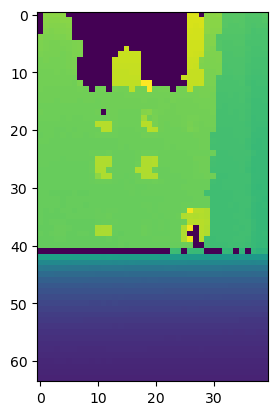

In [338]:
temp = np.zeros([np.shape(images)[1],0])
print(np.shape(temp))
for img_i in range(10,15):
#     print(img_i)
    # fig, ax = p.subplots()
    # ax.imshow(images[img_i,:,:,0])
    temp = np.append(temp,images[img_i,:,:,0], axis = 1)

fig, ax = p.subplots()
ax.imshow(temp)

# # # #get some window in our test
testimg = images[12]
testpose = poses[12]

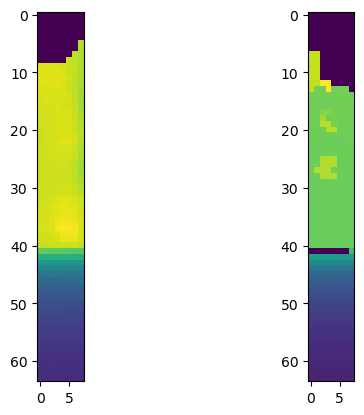

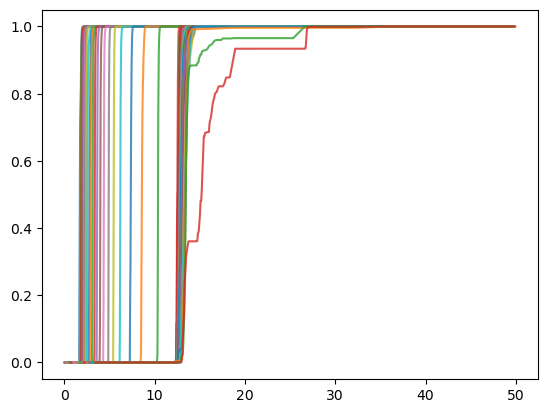

In [339]:
# print(model.summary())
# print(CDF[0,0,:20])
# loss = tf.abs(CDF - gtCDF)
# print(loss)
# loss = tf.reduce_sum(loss)
# print(loss)
# testpose = poses[499]
%matplotlib inline

rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
z_vals = tf.linspace(near, far, N_samples) 
z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals = z_vals[:,:,:,None]
depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)

#~~~~~~~~~~~
#run fine pass through network
#     fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#     rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#     fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#     rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)
test2 = (fwd_test + rev_test) /2 #blur
test2 += 1/(3*N_samples) #shift up slightly
test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
cum_hist_vals = np.cumsum(test2, axis = -1)
randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
cum_hist_vals_flat = cum_hist_vals.flatten()
step_corr = np.linspace(0,W*H-1,W*H)
step_corr = np.tile(step_corr,(N_samples,1)).T
step_corr = np.reshape(step_corr, [1,-1])[0,:]
cum_hist_vals_flat+= step_corr
linear_spaced = np.linspace(near, H*W, N_samples*H*W)
ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
ans -= step_corr
ans *= far
ans = np.abs(ans)
z_vals = np.reshape(ans, [H,W,N_samples,1])
# depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
#~~~~~~~~~~~

fig, ax = p.subplots(1,2)
output = np.flip(depth, axis = 0)
output = output * np.round(np.flip(ray_drop, axis = 0))
ax[0].imshow(output)
ax[1].imshow(testimg[:,:,0])

# print(ray_drop)

fig, ax = p.subplots()
for i in range(np.shape(CDF)[0]):
    for j in range(np.shape(CDF)[1]//8):
#         ax.plot(z_vals[i,j,:-1,0]*50,np.diff(CDF[i,j,:]), alpha = 0.8)
#         ax.plot(z_vals[i,j,:63,0]*50,np.diff(CDF[i,j,:64]), alpha = 0.8)
#         ax.plot(z_vals[i,j,:30,0]*50,CDF[i,j,:30], alpha = 0.8)
        ax.plot(z_vals[i,j,:,0]*50,CDF[i,j,:], alpha = 0.8)

(64, 8, 1) [0.11998405]
(64, 8, 128, 1)


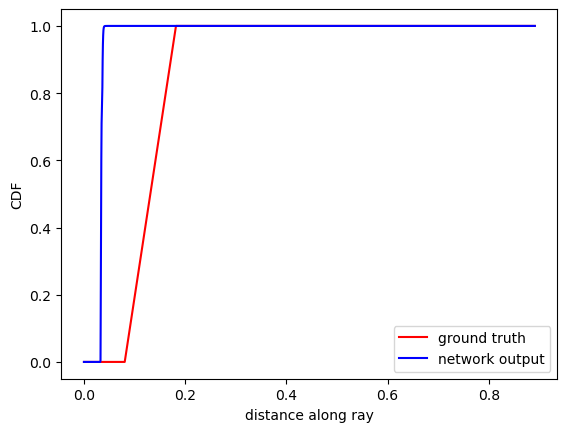

In [340]:
#compare CDF output by network to CDF of target depth image
fig, ax = p.subplots()

#Convert depth output of target image (single value) to CDF
# according to z_vals used in training
print(np.shape(target), target[0,0,:])
print(np.shape(z_vals)) #, z_vals[0,0,:,0])
# print(gtCDF)

#single
gtCDF = z_vals[0,0,:,0] > target[0,0,:]
gtCDF = tf.cast(gtCDF, tf.float32)
ax.plot(z_vals[0,0,:,0], gtCDF, color = 'red', label = "ground truth")
ax.plot(z_vals[0,0,:,0], CDF[0,0,:], color = 'blue', label = "network output")
# #all
# test = z_vals[:,:,:,0] > target[:,:,:]
# test = tf.cast(test, tf.float32)
# for i in range(np.shape(test)[0]):
#     for j in range(np.shape(test)[1]):
#         ax.plot(z_vals[i,j,:,0],test[i,j,:], color = 'red', alpha = 0.1)
#         ax.plot(z_vals[i,j,:,0],CDF[i,j,:], color = 'blue' , alpha = 0.1) 

ax.set_xlabel("distance along ray")
ax.set_ylabel("CDF")
ax.legend(loc = 'lower right')

# Infer point cloud at novel frame

In [393]:
num_view = 128 #128 #number of (rotational?) patches to draw
N_samples = 128 #128 #2048 #does not have to match what was used in training
near=0.
far=1 #2.
n_rots = 128 #128 #number |of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
phimin = np.deg2rad(-15.593) #observed in raw data
phimax = np.deg2rad(17.743)
# phimin = np.deg2rad(-17.743) #TEST
# phimax = np.deg2rad(15.593) #TEST
# phimin = np.deg2rad(-16) #TEST
# phimax = np.deg2rad(16) #TEST
# phimin = np.deg2rad(-5) #test -- trying flipped sign first
# phimax = np.deg2rad(25)  #test

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save poitn cloud to external file

for j in range(num_view):
# for j in np.linspace(0,7,15):
    #get sensor transformation matrix
    rotm = np.eye(4)

    # account for image crop in rotation -------------------
    crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots) #test
    rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

#     #need to account for the fact that the LIDAR beam isn't actually centered at horizon
#     sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
#     rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
    # ------------------------------------------------------

    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
     #courtyard 2
#     rotm[2,-1] = 0.25 #0.25 #x in world frame output
#     rotm[0,-1] = -0.01 #- (i/3) #z in world frame output
#     rotm[1,-1] = -.125 #+ (i/6) #y in world frame
#     # #alt courtyard 1
#     rotm[2,-1] = 0.325  #x in world frame output
#     rotm[0,-1] = 0.008 #z in world frame output
#     rotm[1,-1] = 0.325  #y in world frame
    rotm[2,-1] = 0.45  #x in world frame output
    rotm[0,-1] = 0.01 #z in world frame output
    rotm[1,-1] = 0.40  #y in world frame

    rotm = rotm.astype(np.float32)
    
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
#     print(phimin_patch, phimax_patch)
    
    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
#     depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
    z_vals = tf.linspace(near, far, N_samples) 
    z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals = z_vals[:,:,:,None]
#     depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
#     depth, acc, ray_drop, weights, d1, d2 = render_rays(model, rays_o, rays_d,  z_vals)
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)

#     print(weights[10,3,:])
    
    #~~~~~~~~~~~
    #run fine pass through network
#     fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#     rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#     fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#     rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
    fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
    rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
    fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
    rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)
    test2 = (fwd_test + rev_test) /2 #blur
    test2 += 1/(3*N_samples) #shift up slightly
    test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
    cum_hist_vals = np.cumsum(test2, axis = -1)
    randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
    cum_hist_vals_flat = cum_hist_vals.flatten()
    step_corr = np.linspace(0,W*H-1,W*H)
    step_corr = np.tile(step_corr,(N_samples,1)).T
    step_corr = np.reshape(step_corr, [1,-1])[0,:]
    cum_hist_vals_flat+= step_corr
    linear_spaced = np.linspace(near, H*W, N_samples*H*W)
    ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
    ans -= step_corr
    ans *= far
    ans = np.abs(ans)
    z_vals = np.reshape(ans, [H,W,N_samples,1])
    # depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
    
#     print("z", np.shape(z_vals), z_vals[10,3,:,0])
#     print("old", np.shape(linear_spaced))  
#     print(weights[10,3,:])
#     print(tf.math.reduce_sum(weights[10,3,:]))
    #~~~~~~~~~~~
    
    #TEST---- run through again
    ##TODO-- issue is in using <linear_spaced> a 2nd time since z_vals fed in are not uniform anymore
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    #scale back up to normal size
    depth *= 200 #200 #50 #200
    ray_drop = tf.transpose(ray_drop).numpy() #test
    ray_drop = np.flip(ray_drop, axis = 0) #test
    
    count = 0
    for w in range(W):
        for h in range(H):
# #             #draw all points
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius
            # suppress ray dropped points
            if ray_drop[w,h] > 0.9:
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            # new_point_cloud_spherical[count,1] = (-w+(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots) #test flipping azimuth angle            
            #phi
            #spherical
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(np.shape(depth_img)[1] - 1)) #[17.74,-15.59] #(correct)       
            #TEST -- space linearly in elevation angle (not z)
            # new_point_cloud_spherical[count,2] = np.pi/2 + np.arcsin(phimax - (phimax-phimin)*(h/(np.shape(depth_img)[1] - 1))) #[17.74,-15.59] #(correct)       
            #cylindrical
#             new_point_cloud_spherical[count,2] = (phimax_patch + phimin_patch)/2 - ((-j+((H-1)/2))/(H-1))*(phimax_patch-phimin_patch)

            count+= 1

    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) #need this

    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    #below doesn't work for spherical or cylindrically trained methods
#     new_point_cloud_cart  =cylindrical_to_cartesian(new_point_cloud_spherical).numpy()     
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
#     new_point_cloud_cart[:,1] = -new_point_cloud_cart[:,1] #flip another axis to get back to LHCS (synthetic data only?)

    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
#     # rainbow by z height
#     zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
#     cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
#     disp.append(Points(new_point_cloud_cart, c = cname, r = 2, alpha = 0.5))
    savepc = np.append(savepc, new_point_cloud_cart, axis = 0)

# print(testpose)
# print("\n", rotm)
plt.show(disp, "CDF with L1+L2 Loss, train on 64x8 patches, mask oblique surfaces")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [420]:
#generate a bunch of point clouds at random locations

# print(np.shape(savepc))
print(np.shape(to_save))

# to_save = np.zeros([1,3])
# to_save = np.append(to_save, savepc, axis = 0)

fit_to_map = savepc.copy()
fit_to_map[:,1] -= 200*0.125
fit_to_map[:,0] += 200*0.075
fit_to_map[:,2] -= 200*0.002


# print(np.shape(to_save))
# to_save = np.reshape(to_save, [-1,3])
# np.save("lidar_nerf_demo/generated_pc3.npy", to_save)


plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

disp.append(Points(to_save, c='k', r = 2, alpha = 0.5))
disp.append(Points(fit_to_map, c='red', r = 2, alpha = 0.5))

plt.show(disp, "CDF with L1+L2 Loss, train on 64x8 patches, mask oblique surfaces")
ViewInteractiveWidget(plt.window)

(65537, 3)


ViewInteractiveWidget(height=1199, layout=Layout(height='auto', width='100%'), width=1220)

In [ ]:
# #LOAD [-15,17.5]x1000, @0.005
# np.save("/home/derm/Desktop/poses.npy", poses)
# np.save("/home/derm/Desktop/images.npy", images)
# poses = np.load("/home/derm/Desktop/poses.npy")
# images = np.load("/home/derm/Desktop/images.npy")
#LOAD [-17.5,15]x1000, @0.005
# np.save("/home/derm/Desktop/posesM17P15.npy", poses)
# np.save("/home/derm/Desktop/imagesM17P15.npy", images)
# poses = np.load("/home/derm/Desktop/posesM17P15.npy")
# images = np.load("/home/derm/Desktop/imagesM17P15.npy")

#LOAD [-15,17]x1000, 8x8 @ 0.005
# np.save("/home/derm/Desktop/poses8x8.npy", poses)
# np.save("/home/derm/Desktop/images8x8.npy", images)

# #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
# rotm[:3,-1] *= 0.002 #0.005 #0.02 #0.05
# images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.002 #0.005 #0.02 #0.005 #0.05
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
print(H)
n_vert_patches = 8
H = 8
W = 2

# phimin = np.deg2rad(-17.743) #TEST
# phimax = np.deg2rad(15.593) #TEST
phimin = np.deg2rad(-15.593) #TEST
phimax = np.deg2rad(17.743) #TEST
# phimin = np.deg2rad(-16) #TEST
# phimax = np.deg2rad(16) #TEST
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')

for i in range(9):

#     #bottom to top -- trying this out
#     phimin_patch = phivals[(i%(n_vert_patches))*(64//n_vert_patches)]
#     phimax_patch = phivals[((i+1)%(n_vert_patches))*(64//n_vert_patches)-1]
#     top to bottom -- was this
    idx_first=len(phivals) - (i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
#     phimin_patch = phivals[idx_first]     #was this (wrong??)
#     phimax_patch = phivals[idx_second]    #was this (wrong??)
    phimin_patch = phivals[idx_second]     #test
    phimax_patch = phivals[idx_first]    #test

    #old (sign is opposite of what we want for small patches?)
#     elev_ang = -((phimax_patch + phimin_patch)/2 - ((-j+((H-1)/2))/(H-1))*(phimax_patch-phimin_patch)) -np.pi/2
    #new 7/5
    elev_ang = -(-((phimax_patch + phimin_patch)/2 - ((-j+((H-1)/2))/(H-1))*(phimax_patch-phimin_patch)) + np.pi/2)
    print("\n phimin_patch", np.rad2deg(phimin_patch))
    print("phimax_patch", np.rad2deg(phimax_patch))
    print("elev_ang:", np.shape(elev_ang), np.rad2deg(elev_ang)[:,0] + 90)

In [ ]:
#Use density of returns along each ray in a coarse network to select test points for fine network
from scipy.stats import norm
from scipy.interpolate import interp1d
# %matplotlib notebook

N_samples = 128 # 128
near = 0.
far = 1.
draw_pose = 55

#get rays from model
rays_o, rays_d = get_rays(H, W, poses[draw_pose], vertical_bins[-2], vertical_bins[-1]) #constant validation image
z_vals = tf.linspace(near, far, N_samples) 
# z_vals += 0.0001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals += 1.*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals = z_vals[:,:,:,None]

depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)

#plot density along single pixel
fig, ax = p.subplots(2,1)
ax[0].set_title("Inferred Density Along Ray, n samples = %i" % N_samples)
ax[1].set_xlabel("Distance (m)")
ax[0].set_ylabel("Density")
ax[0].plot(np.linspace(near, far, N_samples),weights[0,1,:], label = "density from coarse network")
# ax[0].plot(np.linspace(near, far, N_samples),test[0,1,:], label = "CDF from coarse network")
ax[0].scatter(depth[0,1], 0., color = 'red')

#fit gaussian to density histogram
x = np.linspace(near,far*50, N_samples)
rolls = np.floor(1000*weights[:,:,:]).astype(int)
mu = np.sum(rolls * np.linspace(near,far*50, N_samples), axis = 2)/1000
sigma = np.sqrt(np.sum(rolls*(mu[:,:,None]-x[None,None,...])**2, axis = 2)/1000)
# ax[0].plot(x, norm.pdf(x, mu[10,1], sigma[10,1]), label="single gaussian");

#apply 2-tap max and 2-tap blur filters used in Mip-NeRF
from numpy.lib.stride_tricks import sliding_window_view
#pad weights with zeros
# fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
# rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#use additional axis to calculate all at once
# fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
# rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)

#blur-pool as vectorized operation
test2 = (fwd_test + rev_test) /2 #blur
# test2 += 1/N_samples #shift up slightly
test2 += 1/(3*N_samples) #shift up slightly
test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
ax[0].plot(np.linspace(near, far, N_samples), test2[0,1,:], label = "2-tap blur-pool + epsilon")
ax[0].set_xlim([-0.1*far,1.1*far])
ax[0].legend()

#calculate and plot inverse distribution~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#resample z_vals for fine network according to the 2-tap blur-pool distribution
st = time.time()

cum_hist_vals = np.cumsum(test2, axis = -1)

randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
# randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
# print("randy:", np.shape(randy))

# print("\n cum_hist_vals:", np.shape(cum_hist_vals))
cum_hist_vals_flat = cum_hist_vals.flatten()

#modify cum_hist_vals so it is monotonically increaseing (needed for interp)
step_corr = np.linspace(0,W*H-1,W*H)
step_corr = np.tile(step_corr,(N_samples,1)).T
step_corr = np.reshape(step_corr, [1,-1])[0,:]
cum_hist_vals_flat+= step_corr

# linear_spaced = np.linspace(near, far*50, N_samples)
# linear_spaced = np.tile(linear_spaced, (H*W))
linear_spaced = np.linspace(near, H*W, N_samples*H*W)
# print("\n linear_spaced:", np.shape(linear_spaced))
# print(linear_spaced)

ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
ans -= step_corr
ans *= far
ans = np.abs(ans)

print("took", time.time() - st, "s")

#~~~~~~~~~~~~~~~

# z_vals = np.reshape(ans, [H,W,1,N_samples])
z_vals = np.reshape(ans, [H,W,N_samples,1])
# z_vals = ans.reshape([W,H,N_samples,1])
# z_vals = np.transpose(z_vals, [1,0,2,3])
print("z_vals", np.shape(z_vals))

# ax[1].scatter(ans[N_samples*count:N_samples*(count+1)], 0.1*np.ones(N_samples), s=2, alpha = 0.5, label = 'sampled points for fine network')
ax[1].scatter(z_vals[0,1,:,0], 0.1*np.ones(N_samples), s=4, alpha = 0.25, label = 'sampled points for fine network')
# ax[1].axis('off')
ax[1].set_ylim([-1,1])
ax[1].set_xlim([-0.1*far,1.1*far])
ax[1].legend(loc='lower right')
# print(z_vals[7,1,:,0])

In [ ]:
#draw nerf output with actual platform trajectory
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)

disp_with_gt = []
fix = np.array([-rotm[1,-1], rotm[2,-1], rotm[0,-1]])*50 
fix += np.array([-initial_pose[0,-1], initial_pose[1,-1], initial_pose[2,-1]])
nerf_in_mapframe = savepc - fix
nerf_in_mapframe = nerf_in_mapframe @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix()
disp_with_gt.append(Points(nerf_in_mapframe, c = 'gray', r = 3, alpha = 0.5))
                    
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
sidx = 7700
eidx = 8700
traj = np.array([gt[sidx:eidx,2], gt[sidx:eidx,3], gt[sidx:eidx,4]]) 
traj = initial_pose[:3,:3] @ traj 
disp_with_gt.append(Points(traj, c = 'red', r = 4))
# disp_with_gt.append(Points([[0,0,0]], c = 'purple', r = 10))

plt.show(disp_with_gt, "Newer College NeRF")
ViewInteractiveWidget(plt.window)

# Test: try probabilisitc rendering from density func

In [ ]:
#Use density of returns along each ray in a coarse network to select test points for fine network
from scipy.stats import norm
from scipy.interpolate import interp1d
%matplotlib inline

N_samples = 128 # 128
near = 0.
far = 2.
draw_pose = 180

#get rays from model
rays_o, rays_d = get_rays(H, W, poses[draw_pose], vertical_bins[-2], vertical_bins[-1]) #constant validation image
z_vals = tf.linspace(near, far, N_samples) 
# z_vals += 0.0001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals += 1.*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals = z_vals[:,:,:,None]

depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)

#plot density along single pixel
fig, ax = p.subplots(2,1)
ax[0].set_title("Inferred Density Along Ray, n samples = %i" % N_samples)
ax[1].set_xlabel("Distance (m)")
ax[0].set_ylabel("Density")
ax[0].plot(np.linspace(near, far, N_samples),weights[0,1,:], label = "density from coarse network")
ax[0].scatter(depth[0,1], 0., color = 'red', label = 'Image-NeRF Accumulation Depth Estimate Coarse')
# ax[1].scatter(z_vals[0,1,:,0], 0.1*np.ones(N_samples), s=4, alpha = 0.25, label = 'sampled points for coarse network')

#fit gaussian to density histogram
x = np.linspace(near,far*50, N_samples)
rolls = np.floor(1000*weights[:,:,:]).astype(int)
mu = np.sum(rolls * np.linspace(near,far*50, N_samples), axis = 2)/1000
sigma = np.sqrt(np.sum(rolls*(mu[:,:,None]-x[None,None,...])**2, axis = 2)/1000)
# ax[0].plot(x, norm.pdf(x, mu[10,1], sigma[10,1]), label="single gaussian");

#apply 2-tap max and 2-tap blur filters used in Mip-NeRF
from numpy.lib.stride_tricks import sliding_window_view
#pad weights with zeros
fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#use additional axis to calculate all at once
fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)

#blur-pool as vectorized operation
test2 = (fwd_test + rev_test) /2 #blur
# test2 += 1/N_samples #shift up slightly
test2 += 1/(3*N_samples) #shift up slightly
test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
ax[0].plot(np.linspace(near, far, N_samples), test2[0,1,:], label = "2-tap blur-pool + epsilon after coarse")
ax[0].set_xlim([-0.1*far,1.1*far])

#calculate and plot inverse distribution~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#resample z_vals for fine network according to the 2-tap blur-pool distribution
st = time.time()

cum_hist_vals = np.cumsum(test2, axis = -1)

randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
print("randy:", np.shape(randy))
# print(randy)

print("\n cum_hist_vals:", np.shape(cum_hist_vals))
cum_hist_vals_flat = cum_hist_vals.flatten()

#modify cum_hist_vals so it is monotonically increaseing (needed for interp)
step_corr = np.linspace(0,W*H-1,W*H)
step_corr = np.tile(step_corr,(N_samples,1)).T #was this
step_corr = np.reshape(step_corr, [1,-1])[0,:]
cum_hist_vals_flat+= step_corr

# linear_spaced = np.linspace(near, far*50, N_samples)
# linear_spaced = np.tile(linear_spaced, (H*W))
linear_spaced = np.linspace(near, H*W, N_samples*H*W) #was this
# linear_spaced = np.linspace(near, H*W, H*W) #test
print("\n linear_spaced:", np.shape(linear_spaced))
# print(linear_spaced)

ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
ans -= step_corr
ans *= far
ans = np.abs(ans)

print("took", time.time() - st, "s")

#~~~~~~~~~~~~~~~

z_vals = np.reshape(ans, [H,W,N_samples,1])
# print("z_vals", np.shape(z_vals))

depth2, acc2, ray_drop2, weights2 = render_rays(model, rays_o, rays_d,  z_vals)
ax[0].scatter(depth2[0,1], 0., color = 'Blue', label = 'Image-NeRF Accumulation Depth Estimate Fine')

#plot latent density of world representation according to fine pass through network
#need to interpolate back to linspace though
normalized_weights2 = np.interp(x=np.linspace(0, 2, N_samples), xp = z_vals[0,1,:,0], fp=weights2[0,1,:]) #test--single sample
normalized_weights2 = normalized_weights2 / (np.sum(normalized_weights2)) #not needed, weights2 already normalized
ax[0].plot(np.linspace(0, 2, N_samples), normalized_weights2, label = "density from fine network") #TEST

# normalized_weights2 = np.interp(x=np.linspace(0, 2, N_samples), xp = z_vals, fp=weights2) #test--single sample
# ax[0].plot(np.linspace(0, 2, N_samples), normalized_weights2, label = "density from fine network") #TEST

# print("weights", np.sum(weights[0,1,:]), weights[0,1,:])
# print("weights2", np.sum(weights2[0,1,:]), weights2[0,1,:])
# print("norm weights2", np.sum(normalized_weights2), normalized_weights2)

ax[1].scatter(z_vals[0,1,:,0], 0.1*np.ones(N_samples), s=4, alpha = 0.25, label = 'sampled points fed to fine network')
#randomly select a point from z_vals as our depth return for this ray
spin = int(N_samples*np.random.rand())
ax[1].scatter(z_vals[0,1,spin,0], 0., color = 'red', label = "Randomly selected depth output from histogram")

# print("random depth:", np.shape(z_vals[:,:,spin,0])) #, z_vals[:10,0,spin,0])
# print("old depth output:", np.shape(depth2)) #,depth2[:10,0])

# ax[1].axis('off')
ax[1].set_ylim([-1,1])
ax[1].set_xlim([-0.1*far,1.1*far])
ax[1].legend(loc='lower right')
ax[0].legend()
# print(z_vals[7,1,:,0])|

In [ ]:
# print(model.summary())

In [ ]:
#save generated point cloud
# fig, ax = p.subplots()
# ax.scatter(savepc[:,0], savepc[:,1])
# np.save('lidar_nerf_demo/generated_pc1.npy', savepc)

In [346]:
#v1-- L_embed = 15 (was 10 before?)
# model.save_weights("models/NCv1.ckpt")
# model.save('models/NCv1.keras')

#v2-- L_embed = 15, trained on 8x8 pixel patches
# model.save_weights("models/NCv2.ckpt")
# model.save('models/NCv2.keras')

#v3-- L_embed = 20, trained on 128,8 cylindrical patches
# model.save_weights("models/NCv3.ckpt")
# model.save('models/NCv3.keras')

#v4-- L_embed = 15, with distortion correction, 
#     trained on 128,8 cylindrical patches, using coarse and fine networks
#     core model trained WITHOUT LiDAR-NeRF structural regularization
#     frames 600:10:1100
# model.save_weights("models/NCv4.ckpt")
# model.save('models/NCv4.keras')

#v5-- L_embed = 18, with DC, frames 7700:10:8700
#     coarse+fine networks
# model.save_weights("models/NCv5.ckpt")
# model.save('models/NCv5.keras')#AD1056380

#v6-- updated netowrk to process positional encoding seprate from view direction
#     trained using spherical patches size [128x8]
# model.save_weights("models/NCv6.ckpt")
# model.save('models/NCv6.keras')

#v7-- larger network, hidden layer size 512, 14 pos embedding dims, 
#     trained using cylindrical patches size [128x8]
#     testing out [-17.5,16] deg for lidar bounds in training data (100 scans)
# model.save_weights("models/NCv7.ckpt")
# model.save('models/NCv7.keras')

#v8-- Standard NeRF structure, patch size [128x8], phimin, max = [-17.75, 16]
#     spherical pathces, accumulate_grad_steps = 32 --> noticiable improvement!
# model.save_weights("models/NCv8.ckpt")
# model.save('models/NCv8.keras')

#v9-- STANDARD NERF, used updated phi min/max 
# model.save_weights("models/NCv9.ckpt")
# model.save('models/NCv9.keras')

#v10-- STANDARD NERF, fixed elevation angle double count
# model.save_weights("models/NCv10.ckpt")
# model.save('models/NCv10.keras')

#v11-- actually fixed double count (forgot to comment out on train script XD)
#      trained from 1000 frames @ size [128,8], no SR,  
# model.save_weights("models/NCv11.ckpt")
# model.save('models/NCv11.keras')

# #v12-- removed intermediary euler conversion in training data -- cylindrical seems to work well now?!?
## flipped bounds
# model.save_weights("models/NCv12.ckpt")
# model.save('models/NCv12.keras')

##v13 -- same as 12 but not flipped
# model.save_weights("models/NCv13.ckpt")
# model.save('models/NCv13.keras')

#synthetic (OG orientation, cylindrical, 30 easy training frames)
# model.save_weights("models/sNCv1.ckpt")
# model.save('models/sNCv1.keras')

#synthetic (Flipped orientation, cylindrical, 100 easy training frames), 14 pos embed dims
# model.save_weights("models/sNCv2.ckpt")
# model.save('models/sNCv2.keras')

#~~~~~BEST OLD~~~~~~~~~~~
#synthetic, flipped orientation, SPHERCIAL (fixed), 100 easy frames, 14 pos embed dims
# model.save_weights("models/sNCv3.ckpt")
# model.save('models/sNCv3.keras')
#~~~~~~~~~~~~~~~~~~~~~~~~

#testing cetering orientation
# model.save_weights("models/sNCv4.ckpt")
# model.save('models/sNCv4.keras')

#real data, de-skew attempt #1, no pinv in GT -- better
# model.save_weights("models/NCv14.ckpt")
# model.save('models/NCv14.keras')

#real data, de-skew attempt #1, with pinv and flipped trans in GT -- worse
# model.save_weights("models/NCv15.ckpt")
# model.save('models/NCv15.keras')

#first attempt at a depth-direct rendered NeRF
# 8,512  18posembed 18angembed
# model.save_weights("models/depthV1.ckpt")
# model.save('models/depthV1.keras')

# # 8,64  18posembed 18angembed
# model.save_weights("models/depthV2.ckpt")
# model.save('models/depthV2.keras')


## MUCH BETTER ON REAL DATA (COURTYARD 1) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#OUTPUT PDF, LOSS AGAINST CDF, stochastic render, L1+L2 Loss 
## 4-tap blur pool, c2f with alpha as "weights", used weights for ray drop (not great...)
# [-17.5,15] load data, [-17.5,15] train
# 1000 training frames
# 8, 256, 14/4
# model.save_weights("models/pdfV1.ckpt")
# model.save('models/pdfV1.keras')

#Notes:
#  slight warping on ground plane
#  able to capture peaks beyond windows
#  better job capturing windows and rough surfaces than previous models
#  slightly messy rings on ground plane

#seems to work even better with [-15,17.5] load, [-17.5, 15.5] train 
# model.save_weights("models/pdfV2.ckpt")
# model.save('models/pdfV2.keras')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#trying same again with learning viewing angle-dependant density -- BEST SO FAR!
# model.save_weights("models/pdfV3.ckpt")
# model.save('models/pdfV3.keras')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# [-17,15] load, 8,512 network
# seems very fragile in training -- network size too big?
# model.save_weights("models/pdfV4.ckpt")
# model.save('models/pdfV4.keras')

# # [-17,15] load, 8,128 network
# model.save_weights("models/pdfV5.ckpt")
# model.save('models/pdfV5.keras')

# trainig on smaller 8x8 patches, messing with phimin_patch min/max
# 15,5 embedding channels, 8,256 network size
# model.save_weights("models/pdfV6.ckpt")
# model.save('models/pdfV6.keras')

#Trying again with full height patches using new phimin/max patch convention... 
# model.save_weights("models/pdfV7.ckpt")
# model.save('models/pdfV7.keras')

#[-15,17] LOAD, [-15,17] TRAIN, training with "prob render" weights
#masking loss in highly obliuque surfaces.
#LOOKS VERY GOOD! -- used to make NCv10.gif
# model.save_weights("models/pdfV8.ckpt")
# model.save('models/pdfV8.keras')


# model.load_weights('models/pdfV8.ckpt')

In [24]:
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

#old theata
# (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots) + np.pi
#broken(?) theta
# (i - (W//2))  /(W) * (2*np.pi/(1024//W)), #just use W
# print(1024//(2*n_rots), (2048//(2*n_rots)), 2*np.pi/n_rots)
# print(W//2, W, 2*np.pi/(1024//W))

phimin_patch = np.deg2rad(-16) 
phimax_patch = np.deg2rad(17.75)

#old phi
# (phimax_patch + phimin_patch)/2 - ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_patch-phimin_patch)
# broken(?) phi
# (phimax_patch + phimin_patch)/2 + ((-j+(H/2))/(H))*(phimax_patch-phimin_patch) #- np.pi/2

print()


# Load and crop depth image data with arbitrary patch sizes

In [39]:
from remove_motion_basic import linear_correction_old as lc

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
sensor_poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
sensor_poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
sensor_poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
sensor_poses = np.einsum("nij,jk->nik", sensor_poses, T_CL)
initial_pose = np.linalg.inv(sensor_poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
sensor_poses = np.einsum("ij,njk->nik", np.linalg.inv(sensor_poses[0]), sensor_poses) #TRY COMMENTING OUT...

#get body frame vel to remove motion disortion from training data
vel_world_frame = np.diff(sensor_poses[:,:3,-1], axis = 0)
vel_body_frame = np.linalg.pinv(sensor_poses[1:,:3,:3]) @ vel_world_frame[:,:,None]
vel_body_frame = vel_body_frame[:,:,0]
#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
window=50
MAx = moving_average(vel_body_frame[:,0], n = window)
MAy = moving_average(vel_body_frame[:,1], n = window)
MAz = moving_average(vel_body_frame[:,2], n = window)
vel_body_frame = np.array([MAx, MAy, MAz]).T

rot_vel_euls = np.diff(R.from_matrix(sensor_poses[:,:3,:3]).as_euler('xyz'), axis = 0)
idx = np.argwhere(rot_vel_euls > (np.pi))
rot_vel_euls[idx] = 0
idx = np.argwhere(rot_vel_euls < (-np.pi))
rot_vel_euls[idx] = 0

pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 5 #10
submap = HD_map[::show_nth]

In [59]:
#  undistort raw point clouds, define patch sizes,
#  take patches about useful regions of the scene, and record poses for each patch 

from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 100 #1000 #50 
n_rots = 128 #128    #number of horizontal patches in 360 degrees
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimaxs

# n_cols_to_skip = 0 #comment out for debug
n_cols_to_skip = n_rots // 8 #remove this much from the beginning and end of each scan
                             #   (need to remove parts of frame containing researcher carrying LIDAR)
#Ouster OS1-64
phimin = np.deg2rad(-15.594) #TEST 7/3
phimax = np.deg2rad(17.743)
# phimax = np.deg2rad(15.594) #flipped
# phimin = np.deg2rad(-17.743)
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots*n_vert_patches,4,4])
images = np.ones([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 2]) #depth image and raydrop
H, W = images.shape[1:3]

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
# disp = []
# submap_in_map_frame =  (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #was this
# # submap_in_map_frame =  (np.append(submap, np.ones([len(submap),1]), axis =1).T).T #initial pose already baked in??
# # submap_in_map_frame = submap_in_map_frame @ np.linalg.pinv(T_CL) #TEST
# submap_in_map_frame = submap_in_map_frame[:,:3]
# disp.append(Points(submap_in_map_frame, c = 'gray', r = 2, alpha = 0.25))

redfix_hist = np.zeros([n_images,4,4])#DEBUG

for i in range(n_images):
    print(i) 
    #2nd courtyard
#     idx = i*60 + 1500
    #full loop first courtyard
#     idx = i + 7700 
    idx = i*10 + 7700
    #test simple part of map
#     idx = i*10 + 8400
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    
#     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
                      -rot_vel_euls[idx,0], #looks good
                      -rot_vel_euls[idx,1],
                      -rot_vel_euls[idx,2]
#                       0,0,0 #rotational velocity is zero-centered (theoretically should cancel out with enough data)
                     ])   
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    # TEST-- Register undistorted PC against HD Map using ICET to correct issues in ground truth------------------------
    submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #test
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3]

    initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 8, 
       draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)

    pc1_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T #test
    pc1_in_map_frame = pc1_in_map_frame[:,:3]
#     disp.append(Points(pc1_in_map_frame, c = 'red', r = 3, alpha = 0.2))

    pc1_corrected_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(it.cloud2_tensor.numpy(), np.ones([len(it.cloud2_tensor.numpy()),1]), axis =1).T).T #test
    pc1_corrected_in_map_frame = pc1_corrected_in_map_frame[:,:3]    
#     disp.append(Points(pc1_corrected_in_map_frame, c = 'blue', r =3, alpha = 0.2))

    #draw red scan corrected by output of ICET
    redFix = np.eye(4)
    redFix[:3,-1] = it.X[:3]
    redFix[:3,:3] = redFix[:3,:3] @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix()
    redfix_hist[i] = redFix
    
    redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
#     redScanFixed = (initial_pose @ sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
    redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
#     disp.append(Points(redScanFixed[:,:3], c = 'red', r =3, alpha = 0.2))    
    #----------------------------------------------------------------------------------------------------------------
    
    #convert to depth image
    pc1_spherical = cartesian_to_spherical(pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
# #         #shift left (nope)
#         data[4*k,:-18] = raw_data[4*k,18:,0]
#         data[4*k+1,:-12] = raw_data[4*k+1,12:,0]
#         data[4*k+2,:-6] = raw_data[4*k+2,6:,0]
#         data[4*k+3,:] = raw_data[4*k+3,:,0]
#         #shift right -- https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts
        data[4*k,:] = raw_data[4*k,:,0]
        data[4*k+1,6:] = raw_data[4*k+1,:-6,0]
        data[4*k+2,12:] = raw_data[4*k+2,:-12,0]
        data[4*k+3,18:] = raw_data[4*k+3,:-18,0]
#         # keep centered
#         data[4*k,1:-8] = raw_data[4*k,9:,0]
#         data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
#         data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
#         data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
#         #TEST-- no shift
#         data = raw_data[:,:,0]
    
    data = np.flip(data, axis =1) #do not comment out

    for j in range(n_rots):
        for k in range(n_vert_patches):
            #get cropped depth image ~~~~~~~~~~~~~~~~~~~~    
            image_width = 1024//n_rots
            image_height = 64//n_vert_patches
            pcs = data[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width] #crop vertically and horizontally
    
            #save depth information to first channel
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] = pcs

            #save raydrop mask to 2nd channel
            a = np.argwhere(abs(pcs) < 1)
            images[k+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0


            #get transformation matrix ~~~~~~~~~~~~~~~~~~
            #works(ish) but "green" axis is upside down, data poisoning from bad ground truth
            # rotm = np.eye(4)
            # rotm[1,3] = -gt[idx,2] #x
            # rotm[2,3] = gt[idx,3] #y
            # rotm[0,3] = -gt[idx,4] #z
            # rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 

#             #use ICET results to improve ground truth
#             rotm = np.eye(4)
#             rotm[1,3] = -(gt[idx,2] + it.X[0]) #x
#             rotm[2,3] = gt[idx,3] + it.X[1] #y
#             rotm[0,3] = -(gt[idx,4] + it.X[2]) #z
#             rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 
#             rotm[:3,:3] = rotm[:3,:3] @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix()

            #TEST ALT GT
#             rotm = initial_pose @ sensor_poses[idx] @ redFix #looks best in visualization (below)
#             rotm = np.linalg.pinv(initial_pose) @ rotm #TEST 6/15

            #centers origin at actual origin of HD map 
            #  need to comment out line in above cell normazlizing sensor_poses w.r.t. first pose
            rotm = sensor_poses[idx] @ redfix_hist[i]
            rotm = np.linalg.pinv(initial_pose) @ rotm

            rotm[:3,-1] = np.array([-rotm[2,-1], -rotm[0,-1], rotm[1,-1]])

            #orient yellow (-z) pointing forward
            fix = np.array([[0,0,1],
                            [1,0,0],
                            [0,1,0]])
            rotm[:3,:3] = rotm[:3,:3] @ fix
            
            swap_axis_matrix = np.array([[0, 0, 1],
                                         [1, 0, 0],
                                         [0, 1, 0]])
            flip_axis_matrix = np.diag([-1,1,-1]) #was this -- trying again 7/5
#             flip_axis_matrix = np.diag([1,1,-1]) # better ---> corrects flipping z issue when rendering
            rotm[:3,:3] = flip_axis_matrix @ swap_axis_matrix @ rotm[:3,:3] 

            #center camera horizontally in each patch
            crop_angle = j*(2*np.pi/n_rots) + (np.pi/n_rots)

            #account for the fact that sensor points back and to the left
            #used this rotation value on the VICET paper-- (I don't think their setup was a perfect 45deg as specified in their paper)
#             crop_angle -= np.deg2rad(44.97)
#             rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
# # # #             #is crop angle already accounted for with redfix(?)
            rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()

            rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

            #courtyard1
            rotm[2,-1] += 45 #translate above xy plane
            rotm[1,-1] += 30 #shift towards positive x
#             rotm[0,-1] += 2 #TEST -- shift up just a little
#             rotm[2,-1] += 120 #courtyard2

            #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
            rotm[:3,-1] *= 0.005 #0.005 #0.02 #0.05
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.005 #0.005 #0.02 #0.005 #0.05
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            # recenter (when using x0.005)
            rotm[2,-1] += 0.25 #translate above xy plane
            rotm[1,-1] += 0.25 #shift towards positive x
            rotm[0,-1] += 0.01 #TEST -- shift up just a little
            
#             poses[j+(i*n_rots)] = rotm
            poses[k+(j+(i*n_rots))*n_vert_patches] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)

print("num poses:", len(poses))

# # Remove patches where sensor is occluded by person holding lidar ~~~~~~~~~~
#calculte how many columns of patches we need to skip at the beginning and end of each scan to avoid
print("n_rots:", n_rots)
# n_cols_to_skip = 0 #debug
print("n_cols_to_skip:", n_cols_to_skip)

bad_idx = np.zeros([0,n_rots - 2*n_cols_to_skip])
a = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
print(np.shape(a))
for i in range(n_vert_patches*n_cols_to_skip):
    bad_i_left = a[i::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_left)
#     print("\n bad_idx_left:", bad_i_left)

    bad_i_right = a[(i+n_vert_patches*(n_rots-n_cols_to_skip))::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_right)
#     print("\n bad_idx_right:", bad_i_right)
    
bad_idx = np.sort(bad_idx)
all_idx = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
good_idx = np.setdiff1d(all_idx, bad_idx).astype(int)

# print(good_idx)

images = images[good_idx,:,:,:]
poses = poses[good_idx,:,:]
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# test on one only
testimg, testpose = images[-1], poses[-1]
images = images[:-1,...,:3]
poses = poses[:-1]

# plt.show(disp, "01 Short Experiment Frame #" + str(idx))
# ViewInteractiveWidget(plt.window)

0
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([-0.0259334   0.01510973 -0.01397576  0.00484101 -0.00061027 -0.00314184], shape=(6,), dtype=float32)
1
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.01260131  0.03992187  0.01251069 -0.01841584 -0.00444439  0.01960293], shape=(6,), dtype=float32)
2
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.1816176   0.03612486 -0.03245923 -0.01576633  0.0126526   0.0120472 ], shape=(6,), dtype=float32)
3
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.19594209  0.04877337 -0.05843383  0.01657923 -0.00312906 -0.01671753], shape=(6,), dtype=float32)
4
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.23347647  0.09044704  0.04658012  0.01076457  0.01209003 -0.00597368], shape=(6,), 

iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.1248638   0.05887499 -0.00688299  0.01566602 -0.01067643 -0.09265588], shape=(6,), dtype=float32)
41
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.16047119  0.19069985  0.01056482 -0.001811    0.00631936  0.00594   ], shape=(6,), dtype=float32)
42
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.1308372   0.10423991  0.01092206 -0.00997467 -0.00295522 -0.0422584 ], shape=(6,), dtype=float32)
43
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.13252765  0.06356172 -0.04383662  0.00007754  0.0012059  -0.01583591], shape=(6,), dtype=float32)
44
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.18320458  0.14709312 -0.01884738  0.00073763  0.00190818  0.0768748 ], shape=(6,), dtype=float32)
45
iter 0
iter 1
iter 2
i

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.11505992 -0.06340965  0.00835771  0.00510716  0.01476779 -0.01614667], shape=(6,), dtype=float32)
82
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.09760312 -0.02882537 -0.01566533  0.01711882 -0.0010056  -0.00972632], shape=(6,), dtype=float32)
83
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.09335846 -0.0119147   0.01717588 -0.00356152 -0.02371212  0.03912529], shape=(6,), dtype=float32)
84
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.09510682  0.01090323 -0.00657958 -0.01547253 -0.01061135 -0.01462171], shape=(6,), dtype=float32)
85
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.12549403  0.00471298 -0.03229618 -0.00642413  0.02455371  0.01040351], shape=(6,)

In [22]:
#draw orientation of frames used for each patch in world frame
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
plt = Plotter(N = 1, axes = 8, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
for i in range(len(poses)):
            
    # #transform each to base frame using <poses>
    # new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    # new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z -- does this indicate an error somewhere???

    #draw frames for each sub-scan 
    alph = 1-(i%(n_rots)/n_rots) #change transparency during scan
#     alph = 1 - i/(len(poses)+1) #change transparency between scans
    #forward view direction (-z in NeRF c2w convention)
    headings = poses[i,:3,:3] @ np.array([0,0,-0.03])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
#     headings = poses[i,:3,:3] @ np.array([.03,0,0])
#     disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = poses[i,:3,:3] @ np.array([0,.03,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
#     headings = poses[i,:3,:3] @ np.array([0,0,.03])
#     disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "blue", alpha = alph))
    
disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Training Data Sample")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [ ]:
#draw subsequent scans aligned using poses with redfix
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for i in range(10):
    idx = i*100 + 7700
#     idx = i*10 + 8400
    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
#     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
                      -rot_vel_euls[idx,0], #looks good
                      -rot_vel_euls[idx,1],
                      -rot_vel_euls[idx,2]
#                       0,0,0 #rotational velocity is zero-centered (theoretically should cancel out with enough data)
                     ])   
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
#     rotm = initial_pose @ sensor_poses[idx] @ redfix_hist[i]  #THIS IS IT -- need to comment out everything below(?)
#     rotm = np.linalg.pinv(initial_pose) @ rotm #was this

    #centers origin at actual origin of HD map 
    #  need to comment out line in above cell normazlizing sensor_poses w.r.t. first pose
    rotm = sensor_poses[idx] @ redfix_hist[i]
    rotm = np.linalg.pinv(initial_pose) @ rotm

#     ##DEBUG-- use same transforms as in training data generatio-----------------
# #     rotm[:3,-1] = np.array([-rotm[2,-1], -rotm[0,-1], rotm[1,-1]])
# #     fix = np.array([[0,0,1],
# #                     [1,0,0],
# #                     [0,1,0]])
# #     rotm[:3,:3] = rotm[:3,:3] @ fix

# #     swap_axis_matrix = np.array([[0, 0, 1],
# #                                  [1, 0, 0],
# #                                  [0, 1, 0]])
# # #             flip_axis_matrix = np.diag([-1,1,-1]) #was this
# #     flip_axis_matrix = np.diag([1,1,-1]) # better ---> corrects flipping z issue when rendering
# #     rotm[:3,:3] = flip_axis_matrix @ swap_axis_matrix @ rotm[:3,:3] 

#     #center camera horizontally in each patch
#     crop_angle = j*(2*np.pi/n_rots) + (np.pi/n_rots)

#     #account for the fact that sensor points back and to the left
#     #used this rotation value on the VICET paper-- (I don't think their setup was a perfect 45deg as specified in their paper)
# #             crop_angle -= np.deg2rad(44.97)
# #             rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
# # # #             #is crop angle already accounted for with redfix(?)
#     rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()
#     rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

#     #courtyard1
#     rotm[2,-1] += 45 #translate above xy plane
#     #--------------------------------------------------------------------------
    
    pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
    
#     pc1_aligned = (np.linalg.pinv(initial_pose) @ pc1_aligned.T).T #TEST --> brings back to origin
    
    disp.append(Points(pc1_aligned[:,:3], c = 'r', r = 2.5, alpha = 0.25))
    

plt.show(disp, "Training Data Sample")
ViewInteractiveWidget(plt.window)

In [ ]:
fig, ax = p.subplots(1,2)
# ax[0].imshow(testimg[:,:,0])
# ax[1].imshow(testimg[:,:,1], vmin=0, vmax=1)

idx = 10
ax[0].imshow(images[idx,:,:,0])
ax[1].imshow(images[idx,:,:,1], vmin=0, vmax=1)

# ax[0].imshow(testimg[:,:,0])
# ax[1].imshow(testimg[:,:,1], vmin=0, vmax=1)

# print(images[idx,:,:,1])

In [ ]:
print(np.shape(poses))
fig, ax = p.subplots()
# ax.scatter(-poses[0,1,-1],poses[0,2,-1])
ax.scatter(-poses[:,1,-1],poses[:,2,-1])
# ax.scatter(-poses[:200,1,-1],poses[:200,2,-1])
ax.set_aspect("equal")
print(np.shape(poses))

In [ ]:
print(np.shape(poses))
fig, ax = p.subplots()
ax.plot(poses[:,2,-1], poses[:,1,-1])
ax.set_aspect(1)

In [118]:
#generate and visualize "dirs" points according to poses and patch specs
#OLD- USING SPHERICAL POINT PROJECTION

num_draw = 64 #128 #48 #number of patches to draw
N_samples = 64 #only when visualizing all test points

#Ouster OS1-64
# phimin = np.deg2rad(-15.594)
# phimax = np.deg2rad(17.743)
phimin = np.deg2rad(-5) #debug
phimax = np.deg2rad(27)
# phimin = np.deg2rad(-27) #debug
# phimax = np.deg2rad(5)
# phimax = np.deg2rad(15.594) #test
# phimin = np.deg2rad(-17.743)

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
print(H, W)

#test
vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True, sharecam = False) #axes = 4 (simple), 1(scale)
disp=[]

for count in range(num_draw):
    
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    look_at_pose = count
    c2w = poses[look_at_pose]
    c2w = tf.cast(c2w, tf.float32)
    near = 0.
    far = 64.
        
    #was this
#     phimin_temp = vertical_bins[count%n_vert_patches] 
#     phimax_temp = vertical_bins[count%n_vert_patches + 1]
    #test -- send bins from top to bottom
    phimin_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches+1)] 
    phimax_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches)]

    #reformat for LiDAR depth measurements ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    vert_fov = np.rad2deg(phimax-phimin)
    #[r, theta, phi]
    dirs_test = tf.stack([-tf.ones_like(i), #r
                          #theta
                          (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots), #for uninterpolated images
                          #phi
#                         (phimax_temp + phimin_temp)/2 + ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_temp-phimin_temp) -np.pi/2
                          #TEST-- linear ANGULAR spacing
                          np.arcsin((phimax_temp + phimin_temp)/2 + ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_temp-phimin_temp)) -np.pi/2
#                           -(-((phimax_patch + phimin_patch)/2 - ((-j+((H-1)/2))/(H-1))*(phimax_patch-phimin_patch)) + np.pi/2) #TEST 7/5
                         ], -1)
    dirs_test = tf.reshape(dirs_test,[-1,3])
#     dirs_test = LC.s2c(LC, dirs_test)    #was this
    dirs_test = spherical_to_cartesian(dirs_test)  #does the same thing
    
    #need to rotate red points into same frame as blue points 
#     rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix() #was this
    rotm = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix() #test
    dirs_test = dirs_test @ rotm
    dirs_test = dirs_test @ tf.transpose(c2w[:3,:3])

    dirs_test = dirs_test @ (c2w[:3,:3] 
                          @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix() #looked good but converged slightly off
                          @ np.linalg.pinv(c2w[:3,:3]) )

    rotm_fix = (c2w[:3,:3] 
                @ np.linalg.pinv(c2w[:3,:3]))
    rays_d_test = tf.reduce_sum(dirs_test[..., np.newaxis, :] * rotm_fix, -1) #looks like I need to do this instead
    rays_o_test = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d_test))
    z_vals_test = tf.linspace(near, far, N_samples) 
    z_vals_test += tf.random.uniform(list(rays_o_test.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts_test = rays_o_test[...,None,:] + rays_d_test[...,None,:] * z_vals_test[...,:,None]
    pts_flat_test = tf.reshape(pts_test, [-1,3])

#     #random color
#     cname = np.array([255*(np.random.rand()), 255*(np.random.rand()), 255*(np.random.rand())]).T.tolist()
    #use depth as color
#     d = images[count,:,:,0].flatten()
    d = images[30*num_draw + count,:,:,0].flatten()
#     cname = np.array([d/1.5, d/1.5, d/1.5]).T.tolist()
    cname = np.array([d*2, d*2, d*2]).T.tolist()

#     disp.append(Points(pts_flat_test, c = cname, r = 3, alpha = 0.5)) 
    disp.append(Points(dirs_test, c = cname, r = 3, alpha = 0.75))
#     disp.append(Points(dirs_test, c = 'pink', r = 3, alpha = 0.8))
    disp.append(Points(dirs_test[:10], c = 'red', r = 5, alpha = 0.8))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #draw frames first pose
    #forward view direction (-z in NeRF c2w convention) 
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,-0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "yellow"))
    # x
    headings = poses[look_at_pose,:3,:3] @ np.array([0.3,0,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "red"))
    #y
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0.3,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "green"))
    #z
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "blue"))

plt.show(disp, "dirs", at = 0)
ViewInteractiveWidget(plt.window)

64 8


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [119]:
#generate and visualize "dirs" points according to poses and patch specs

#TEST-- try using cylindrical point projection to generate dist

num_draw = 16 #128 #48 #number of patches to draw
N_samples = 64 #only when visualizing all test points
#IMPORTANT-- this needs to match values used when setting up training data 
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

#Ouster OS1-64
phimin = np.deg2rad(-15) 
phimax = np.deg2rad(17.75)
# phimin = np.deg2rad(-17.75) 
# phimax = np.deg2rad(16)
# phimin = np.deg2rad(-55) 
# phimax = np.deg2rad(55)

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True, sharecam = False) #axes = 4 (simple), 1(scale)
disp=[]

for count in range(num_draw):
    
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    look_at_pose = count
    c2w = poses[look_at_pose]
    c2w = tf.cast(c2w, tf.float32)
    near = 0.
    far = 2.
        
    #send bins from top to bottom
    phimin_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches+1)] 
    phimax_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches)]

    #reformat for LiDAR depth measurements ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    vert_fov = np.rad2deg(phimax-phimin)
    #[r, theta, phi]
    dirs_test = tf.stack([-tf.ones_like(i), #r
                          #theta
                          (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots) + np.pi,
                          #phi
                          #OLD-- constant spacing vertical direction (not quite right) 
#                           (phimax_temp + phimin_temp)/2 - ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_temp-phimin_temp) 
                          #NEW-- constant spacing in elevation ANGULAR direction
                          np.arcsin((phimax_temp + phimin_temp)/2 - ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_temp-phimin_temp))                          
                         ], -1)
    dirs_test = tf.reshape(dirs_test,[-1,3])
    dirs_test = cylindrical_to_cartesian(dirs_test)

    #need to rotate red points into same frame as blue points 
#     rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix() #was this
    rotm = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix() #test
    dirs_test = dirs_test @ rotm
    dirs_test = dirs_test @ tf.transpose(c2w[:3,:3])
    # aligns dirs, doesn't get pts_flat to work yet
    dirs_test = dirs_test @ (c2w[:3,:3] 
                          @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix() #looked good but converged slightly off
                          @ np.linalg.pinv(c2w[:3,:3]) )

    rotm_fix = (c2w[:3,:3] 
                @ np.linalg.pinv(c2w[:3,:3]))
    rays_d_test = tf.reduce_sum(dirs_test[..., np.newaxis, :] * rotm_fix, -1) #looks like I need to do this instead
    rays_o_test = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d_test))
    z_vals_test = tf.linspace(near, far, N_samples) 
    z_vals_test += tf.random.uniform(list(rays_o_test.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts_test = rays_o_test[...,None,:] + rays_d_test[...,None,:] * z_vals_test[...,:,None]
    pts_flat_test = tf.reshape(pts_test, [-1,3])

    #random color
    cname = np.array([255*(np.random.rand()), 255*(np.random.rand()), 255*(np.random.rand())]).T.tolist()
    #use depth as color
# #     d = images[count,:,:,0].flatten()
#     d = images[30*num_draw + count,:,:,0].flatten()
#     cname = np.array([d/1.5, d/1.5, d/1.5]).T.tolist()
    
#     print(np.shape(pts_flat_test), np.shape(poses[count,-1,:3][:,None]))

    centered = pts_flat_test - poses[count,:3,-1]
    
#     disp.append(Points(pts_flat_test, c = cname, r = 3, alpha = 0.125)) 
#     disp.append(Points(centered, c = cname, r = 3, alpha = 0.125)) 
    disp.append(Points(dirs_test, c = cname, r = 3, alpha = 0.5))
#     disp.append(Points(dirs_test, c = 'pink', r = 3, alpha = 0.8))
    disp.append(Points(dirs_test[:10], c = 'red', r = 5, alpha = 0.8))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #draw frames first pose
    #forward view direction (-z in NeRF c2w convention) 
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,-0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "yellow"))
    # x
    headings = poses[look_at_pose,:3,:3] @ np.array([0.3,0,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "red"))
    #y
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0.3,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "green"))
    #z
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "blue"))

plt.show(disp, "dirs", at = 0)
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [ ]:
fig, ax = p.subplots()
delta_z = np.diff(np.deg2rad(dirs_test[::8,0]))
ax.plot(delta_z)
ax.set_title("change in z per elevation angle")

In [ ]:
#debug: view grid of patches
n_vert_patches = 8
view_scan_num = 8 #which scan to look at
num_view_rots = 10

fig, ax = p.subplots(n_vert_patches, num_view_rots)

for i in range(num_view_rots):
    for j in range(n_vert_patches):
        ax[j,i].imshow(images[num_draw*view_scan_num + j + i*n_vert_patches,:,:,0])#, vmin = 0, vmax = 1)
#         ax[j,i].imshow(np.flip(images[-(j + i*n_vert_patches),:,:,0], axis = 0), vmin = 0, vmax = 4)
        ax[j,i].get_xaxis().set_visible(False)
        ax[j,i].get_yaxis().set_visible(False)
        ax[j,i].set_aspect(W/H)
# p.subplots_adjust(wspace=0.1, hspace=0.1)

In [ ]:
## view patches (assumes sigle n_vert_patches == 1)
# %matplotlib notebook
fig, ax = p.subplots(2,5)
ax[0,0].set_title("depth image patches for training")

# ax[0,0].imshow(images[0,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[1,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[2,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[3,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[4,:,:,0])#, vmin=0, vmax=64)

# ax[0,0].imshow(images[-20,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[-19,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[-18,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[-17,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[-16,:,:,0])#, vmin=0, vmax=64)

ax[0,0].imshow(images[-4,:,:,0])#, vmin=0, vmax=64)
ax[0,1].imshow(images[-3,:,:,0])#, vmin=0, vmax=64)
ax[0,2].imshow(images[-2,:,:,0])#, vmin=0, vmax=64)
ax[0,3].imshow(images[-1,:,:,0])#, vmin=0, vmax=64)
ax[0,4].imshow(testimg[:,:,0])#, vmin=0, vmax=64)

ax[1,0].set_title("ray drop masks")
ax[1,0].imshow(images[-4,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,1].imshow(images[-3,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,2].imshow(images[-2,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,3].imshow(images[-1,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,4].imshow(testimg[:,:,1],cmap="gray", vmin=0,vmax=1)

In [ ]:
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
print(phimin, phimax)

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
print(vertical_bins, "\n")

for count in range(10):
    phimin_temp = vertical_bins[count%n_vert_patches] 
    phimax_temp = vertical_bins[(count)%n_vert_patches + 1]
    print(phimin_temp, phimax_temp)


# Animate GIF

In [ ]:
#figure out translation using GT
# fig, ax = p.subplots()
sidx = 550
eidx = 1000
# ax.plot(gt[sidx:eidx,2], gt[sidx:eidx,3])
# ax.set_aspect('equal')
# print(gt[0,2:5]/50)
print(rotm)

In [244]:
num_frames = 50
num_view = 64 #128 #number of (rotational?) patches to draw
n_rots = 64 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax
N_samples = 128 #64 #does not have to match what was used in training?? 

H = 64
W = 1024 // n_rots

for i in range(num_frames):
    print(i)
    plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), offscreen=True)
    disp=[] 
    
    for j in range(num_view):
        rotm = np.eye(4)
        # account for image crop in rotation -------------------
#         crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots) #old
        crop_angle =  -(np.pi/n_rots) - j*(2*np.pi/n_rots) #test
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
        # ------------------------------------------------------

        # flip x and z axis
        rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

        rotm[0:3,2] *= -1 # flip sign of y and z axis
        rotm[0:3,1] *= -1
        rotm = rotm[[1,0,2,3],:]
        rotm[2,:] *= -1 # flip whole world upside down
#         rotm[2,-1] = 0.25 + (i/100) #x in world frame output
#         rotm[0,-1] = -0.02 #-0.003 #- (i/3) #z in world frame output
#         rotm[1,-1] = .5 + (i/100) #y in world frame
#         rotm[2,-1] = 0.5 #x in world frame output
#         rotm[0,-1] = -0.02 #-0.003 #- (i/3) #z in world frame output
#         rotm[1,-1] = .25 + (i/100) #y in world frame
        rotm[2,-1] = 0.325 #x in world frame output
        rotm[0,-1] = 0.005 #-0.003 #- (i/3) #z in world frame output
        rotm[1,-1] = 0.325  + (i/400)

        # #test using gt ~~~~~~~~~~
        # # start: [-0.0671118   0.165084    0.00291402]
        # rotm[1,-1] = gt[10*i+700,2]/50 #x in world frame output
        # rotm[2,-1] = -gt[10*i+700,3]/50 #y in world frame -- need to account for how we translated training data
        # rotm[0,-1] = -gt[10*i+700,4]/50 - 45/50 #z in world frame output
        # print(rotm[:,-1])
        # #~~~~~~~~~~~~~~~~~~~~~~~~
        
        rotm = rotm.astype(np.float32)

        # phimin = np.deg2rad(-15.594) 
        # phimax = np.deg2rad(17.743)
        phimax = np.deg2rad(15.594)#FLIPPED 
        phimin = np.deg2rad(-17.743)
#         phimax = np.deg2rad(16)#centered (debug only) 
#         phimin = np.deg2rad(-16)
        
        vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
        phimin_patch = vertical_bins[img_i%n_vert_patches] 
        phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

        #call NeRF using specified novel rotm
        rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    #     depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)

        #~~~~~~~~~~~
        #run fine pass through network
        fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
        rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
        fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
        rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
        test2 = (fwd_test + rev_test) /2 #blur
        test2 += 1/(3*N_samples) #shift up slightly
        test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
        cum_hist_vals = np.cumsum(test2, axis = -1)
        randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
        cum_hist_vals_flat = cum_hist_vals.flatten()
        step_corr = np.linspace(0,W*H-1,W*H)
        step_corr = np.tile(step_corr,(N_samples,1)).T
        step_corr = np.reshape(step_corr, [1,-1])[0,:]
        cum_hist_vals_flat+= step_corr
        linear_spaced = np.linspace(near, H*W, N_samples*H*W)
        ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
        ans -= step_corr
#         ans *= 2
        ans = np.abs(ans)
        z_vals = np.reshape(ans, [H,W,N_samples,1])
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        #~~~~~~~~~~~

        new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
        depth = tf.transpose(depth).numpy() #need this
        depth = np.flip(depth, axis = 0) #needed

        #scale back up to normal size
        depth *= 200 #60 #20
        ray_drop = tf.transpose(ray_drop).numpy() #test
        ray_drop = np.flip(ray_drop, axis = 0) #test

        count = 0
        for w in range(W):
            for h in range(H):
    #             #draw all points
#                 new_point_cloud_spherical[count,0] = depth[w,h] #radius
#                 suppress ray dropped points
                if ray_drop[w,h] > 0.95:
                        new_point_cloud_spherical[count,0] = depth[w,h] #radius
                else:
                        new_point_cloud_spherical[count,0] = 0#100
                new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)            

                #space linearly in z
                new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(np.shape(depth_img)[1] - 1)) #BETTER(?)
                #space linearly in elevation angle
                # new_point_cloud_spherical[count,2] = np.pi/2 + np.arcsin(phimax - (phimax-phimin)*(h/(np.shape(depth_img)[1] - 1))) #[17.74,-15.59] #(correct)       
    
                count+= 1

#         new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) #old
        new_point_cloud_spherical[:,1] -= (np.pi/n_rots) + j*(2*np.pi/n_rots) #test

        new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
        new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
#         new_point_cloud_cart[:,1] = -new_point_cloud_cart[:,1] #for synthetic data
        
        #translate to keep camera fixed in place
        new_point_cloud_cart[:,0] += -3.5 + 15*i/30
        new_point_cloud_cart[:,2] += -10
  
        disp.append(Points(new_point_cloud_cart, c = 'grey', r = 2, alpha = 0.375))
#         # rainbow by z height
#         zheight = 65*(np.sin(0.0625*new_point_cloud_cart[:,2])+11)
#         cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
#         disp.append(Points(new_point_cloud_cart, c = cname, r = 2, alpha = 0.25))
        
    #for raw data
    cam = dict(
        pos=(37.30093, 95.07558, 94.30112),
        focalPoint=(8.715815, 0.7997105, -0.04585656),
        viewup=(-0.2068594, -0.6600254, 0.7222019),
        distance=136.4053,
        clippingRange=(53.80149, 240.4701),
    )
#     #synthetic data
#     cam = dict(
#     pos=(10.65918, -107.0537, 101.1803),
#     focalPoint=(11.55028, -1.807423, 1.020487),
#     viewup=(0.01507708, 0.6892402, 0.7243760),
#     distance=145.2913,
#     clippingRange=(85.29556, 214.5295),
#     )

    plt.show(disp, "Novel Point Cloud From NeRF at [" 
             + str(np.round(-rotm[2,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[1,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[0,-1]*20, decimals=2)) + "]",
             camera= cam).screenshot("lidar_nerf_demo/Newer_College_V2_" + str(i) + ".png")
#     plt.show(disp, "Novel Point Cloud From NeRF at [" 
#              + str(np.round(-rotm[2,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[1,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[0,-1]*20, decimals=2)) + "]").screenshot("lidar_nerf_demo/Newer_College_V2_" + str(i) + ".png")
    plt.clear()
    plt.close()
# ViewInteractiveWidget(plt.window)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Remove motion distortion from raw point cloud data used to train NeRF

I believe directly training on motion-distorted raw point clouds is responsible for the "wiggly" motion of some walls observed in the rendered GIFs 

In [ ]:
#load HD Map
pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 5 #10
submap = HD_map[::show_nth]
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(submap, c = "gray", r = 2.5, alpha = 0.2)) 
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

In [ ]:
idx = 7800 #1450 #700    
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
fn2 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx +1) + ".npy"
pc1 = np.load(fn1)
pc2 = np.load(fn2)
# pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET
# pc2 = np.flip(pc2, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

In [ ]:
dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)

seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
sensor_poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
sensor_poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
sensor_poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
sensor_poses = np.einsum("nij,jk->nik", sensor_poses, T_CL)
initial_pose = np.linalg.inv(sensor_poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
sensor_poses = np.einsum("ij,njk->nik", np.linalg.inv(sensor_poses[0]), sensor_poses)

# print(poses)

In [ ]:
# %matplotlib notebook

#TODO: get body-frame euler angles from ground truth
fig, ax = p.subplots(4,2)
start_idx = 500
end_idx = 800

ax[0,0].set_title("frames from ground truth")
ax[0,0].plot(sensor_poses[start_idx:end_idx,0,-1], sensor_poses[start_idx:end_idx,1,-1])
ax[0,0].set_aspect(1)

#plot velocity in world frame
vel_world_frame = np.diff(sensor_poses[:,:3,-1], axis = 0)
ax[1,0].set_title("x vel in world frame")
ax[1,0].plot(vel_world_frame[start_idx:end_idx,0])
ax[1,1].set_title("y vel in world frame")
ax[1,1].plot(vel_world_frame[start_idx:end_idx,1])

#get velocity in body frame
# rotm = R.from_euler('xyz',[0,0,3*np.pi/4]).as_matrix()
rotm = R.from_euler('xyz',[0,0,0]).as_matrix()
# vel_body_frame = poses[1:,:3,:3] @ rotm @ vel_world_frame[:,:,None]
vel_body_frame = np.linalg.pinv(sensor_poses[1:,:3,:3]) @ rotm @ vel_world_frame[:,:,None]

vel_body_frame = vel_body_frame[:,:,0]
ax[2,0].set_title("x vel body frame")
ax[2,0].plot(vel_body_frame[start_idx:end_idx,0])
ax[2,1].set_title("y vel body frame")
ax[2,1].plot(vel_body_frame[start_idx:end_idx,1])

#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

window=50
MAx = moving_average(vel_body_frame[:,0], n = window)
ax[3,0].plot(MAx[start_idx:end_idx+window-1])
ax[3,0].set_title("smoothed x vel (body frame)")
MAy = moving_average(vel_body_frame[:,1], n = window)
ax[3,1].plot(MAy[start_idx:end_idx+window-1])
ax[3,1].set_title("smoothed y vel (body frame)")
MAz = moving_average(vel_body_frame[:,2], n = window)

vel_body_frame = np.array([MAx, MAy, MAz]).T

#plot heading on map
for i in range(start_idx,end_idx,100):
    heading = np.array([5,0,0]) @ np.linalg.pinv(sensor_poses[i, :3, :3]) @ rotm
    end = sensor_poses[i, :3, -1] + heading
    ax[0,0].plot([sensor_poses[i,0,-1], end[0]], [sensor_poses[i,1,-1], end[1]], color='red' )

    heading = np.array([0,5,0]) @ np.linalg.pinv(sensor_poses[i, :3, :3]) @ rotm
    end = sensor_poses[i, :3, -1] + heading
    ax[0,0].plot([sensor_poses[i,0,-1], end[0]], [sensor_poses[i,1,-1], end[1]], color='green' )

In [ ]:
#get rotational velocity
#get straight diff (was this)-- not going to work?
rot_vel_euls = np.diff(R.from_matrix(sensor_poses[:,:3,:3]).as_euler('xyz'), axis = 0)

# rot_vel_euls = np.zeros([len(poses)-1,3])
# for i in range(1,len(poses)):
#     pose_i_in_last_frame = np.linalg.pinv(poses[i-1,:3,:3]) @ poses[i,:3,:3]
#     end = R.from_matrix(sensor_pose_i_in_last_frame).as_euler('xyz')
#     rot_vel_euls[i-1] = end - R.from_matrix(poses[i-1,:3,:3]).as_euler('xyz')
# rot_vel_euls = np.diff(rot_vel_euls, axis = 0)

fig, ax = p.subplots(3)
ax[0].plot(rot_vel_euls[start_idx:end_idx,0])
ax[0].set_label("roll")
ax[1].plot(rot_vel_euls[start_idx:end_idx,1])
ax[1].set_label("pitch")
ax[2].plot(rot_vel_euls[start_idx:end_idx,2])
ax[2].set_label("yaw")

In [ ]:
m_hat = np.array([-vel_body_frame[idx,0],
                  -vel_body_frame[idx,1],
                  -vel_body_frame[idx,2],
                  -rot_vel_euls[idx,0],
                  -rot_vel_euls[idx,1],
                  -rot_vel_euls[idx,2]
                  # 0,0,0
                 ])
# from old version of VICET (very slow)
# from remove_motion_basic import linear_correction_old as lc
# rectified_pc1 = lc(pc1, m_hat, period_lidar=1.)
#much faster
rectified_pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)

pc1 = np.flip(pc1, axis = 0)# uncomment at the end to get image projection to work
rectified_pc1 = np.flip(rectified_pc1, axis = 0)# uncomment at the end to get image projection to work

In [ ]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#transform map to pc1 frame (for debug)
# submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #test

submap_in_pc1_frame = submap_in_pc1_frame[:,:3]

disp.append(Points(submap_in_pc1_frame, c = "black", r = 3, alpha = 0.1)) ##CB2314


# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
# disp.append(Points(rectified_pc1, c = '#2c7c94', r = 3)) #blue
## purple -> green
color = 255*np.linspace(0,1,len(rectified_pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(rectified_pc1, c=cname,  r = 3.5, alpha =0.5))


plt.show(disp, "01 Short Experiment Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

# Generate fake LIDAR scans from HD Map

In [ ]:
def gen_scan_from_map(hd_map, p, res = [64, 1024], 
                      phimin = np.pi/2 + np.deg2rad(-17.743), 
                      phimax = np.pi/2 + np.deg2rad(15.594), 
                      tol = 0.001, use_IP = True):
    """p = pose, homogemous coordinates"""
        
    #align hd map about origin according to pose
    if use_IP:
        centered_map = (np.linalg.pinv(p) @ initial_pose @ np.append(hd_map, np.ones([len(hd_map),1]), axis =1).T).T
    else:
        centered_map = (np.linalg.pinv(p) @ np.append(hd_map, np.ones([len(hd_map),1]), axis =1).T).T
    centered_map_s = cartesian_to_spherical(centered_map)
    
    #remove points outside vertical fov
    centered_map_s = centered_map_s[centered_map_s[:,2] > phimin]
    centered_map_s = centered_map_s[centered_map_s[:,2] < phimax]
    centered_map_s = centered_map_s[centered_map_s[:,0]< 100]
    
    #test looking at narrow azimuth range
    #sort by azimuth angle
    centered_map_s = centered_map_s.numpy()
    sorted_indices = centered_map_s[:,1].argsort() #[-pi, pi]
    centered_map_s = centered_map_s[sorted_indices]

    #just keep points that are within tol of a phi angle
    scan = np.zeros([0,3])
    gp = np.linspace(phimin, phimax, res[0]) #good phis

    #loop through each horizontal angle
    for j in range(res[1]):
        centered_map_s_slice = centered_map_s[centered_map_s[:,1] > (-np.pi + (2*np.pi*j/res[1]))]
        centered_map_s_slice = centered_map_s_slice[centered_map_s_slice[:,1] < (-np.pi + (2*np.pi*(j+1)/res[1]))]
#         print(j)
        
        #loop through each elevation angle
        for i in range(res[0]):
            tol_temp = tol
            good = np.zeros([0,3])
            count = 0
            #gradually up tolerance about sampling angle until sufficient number of points are captured in scan line
            # or increasing tolerance no longer helps
            while (np.shape(good)[0] < (3*1024)//(res[1])):
                good = centered_map_s_slice[abs(centered_map_s_slice[:,2] - gp[i]) < tol_temp ]
                tol_temp *= 1.5
                if count > 5:
                    np.zeros([0,3])
                    break
                count += 1

            #add closest point to scan, give it theoretical target elevation and azimuth
            if len(good) >= 1:
                best_r = min(good[:,0])
            else:
                best_r = 0
            best_point_s = np.array([[best_r, -np.pi + np.pi/res[1] + (2*np.pi*j/res[1]), gp[i]]]) #[r, elev, azim]
            scan = np.append(scan, best_point_s, axis = 0)
        
    scan = spherical_to_cartesian(scan)
    return scan

In [ ]:
def create_random_scan(HD_map, scan_dims = [64,1024], phimin = np.deg2rad(-15.594), phimax = np.deg2rad(17.743)):
    phimin += np.pi/2 
    phimax += np.pi/2
    
    newPose = np.eye(4)
    #[-53, -5]x, [-10,10]y, [0.5,3]z
    trans = np.array([-43,-5,0.5]) + np.array([28,10,2.5])*np.random.rand(3) #just center of courtyard
#     trans = np.array([-53,-10,0.5]) + np.array([48,20,2.5])*np.random.rand(3) #full space
    trans_mapframe = R.from_euler('xyz', [0,0,np.pi/4]).as_matrix() @ trans #rotate to map coordinate system
    newPose[0:3,-1] = trans_mapframe
    simulated_scan = gen_scan_from_map(HD_map, newPose, res = scan_dims, phimin = phimin, phimax = phimax)[:,:3]
    # simulated_scan = gen_scan_from_map(HD_map, newPose, res = scan_dims, phimin = np.pi/2 + np.deg2rad(-20), phimax = np.pi/2 + np.deg2rad(10))[:,:3] #debug
    
#     simulated_scan = None #temp for debug only
    
    return(newPose, simulated_scan)

# Need to get better ground truth for LIDAR scans

* Remove translational motion distortion from raw scans using smoothed gt velocity
* Downsample HD Map using growing cones strategy
* Register undistorted PC against HD map using ICET
* Use output of ICET to update gt
* Train NeRF

In [ ]:
#downsample HD Map to resemble LIDAR scan
newPose = np.eye(4)
simulated_scan = gen_scan_from_map(submap_in_pc1_frame, newPose, res = [64,128], use_IP = False)[:,:3]

initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
#resutlts with full cloud: [ 0.27173612  0.07726155 -0.02524593  0.00388683  0.0106992  -0.02185947]
it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 70, niter = 10, 
       draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
#result with simulated scan: [ 0.2829418   0.07808943 -0.00657902  0.00399441  0.01081101 -0.02118503] (pretty much the same)
# it = ICET(cloud1 = simulated_scan, cloud2 = pc1, fid = 70, niter = 10, 
#        draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
disp = []
disp.append(Points(pc1, c = 'red', r =3))
disp.append(Points(it.cloud2_tensor.numpy(), c = 'blue', r =3))
disp.append(Points(simulated_scan, c = 'black', r = 3, alpha = 0.5))
disp.append(Points(submap_in_pc1_frame, c = 'gray', r = 2, alpha = 0.25))
# disp.append(Points(submap, c = 'purple', r = 2, alpha = 0.1))
plt.show(disp, "01 Short Experiment Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

In [ ]:
# idx = 7900 #7800
# newPose = sensor_poses[idx].copy()
# newPose = newPose @ np.linalg.pinv(initial_pose)
# newPose = initial_pose.copy()
# newPose[:3,:3] = newPose[:3,:3] @ R.from_euler('xyz', [0,0,np.pi/4]).as_matrix() #rotate 45 deg about z
# newPose[0,-1] = -15 #-30 + np.random.rand()*15 #[-5,-30]
# newPose[1,-1] = 0 #-25 + np.random.rand()*10 #[-15, -25]
# newPose[2,-1] = 0.5 + np.random.rand()*2 #[1,3]

p1, s1 = create_random_scan(HD_map, scan_dims = [64, 128], phimin = np.deg2rad(-15.594), phimax = np.deg2rad(17.743))
p2, s2 = create_random_scan(HD_map, scan_dims = [64, 128], phimin = np.deg2rad(-5), phimax = np.deg2rad(25))
p3, s3 = create_random_scan(HD_map, scan_dims = [64, 128])

# gt_submap = (np.linalg.pinv(newPose) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
gt_submap = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# gt_submap = (np.linalg.pinv(newPose) @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# gt_submap = (np.linalg.pinv(newPose) @ np.append(HD_map_rotated, np.ones([len(HD_map_rotated),1]), axis =1).T).T
# gt_submap = (np.linalg.pinv(newPose) @ initial_pose @ np.append(HD_map, np.ones([len(HD_map),1]), axis =1).T).T

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
color = 255*np.linspace(0,1,len(s1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(p1[0:3,-1] + s1, c=cname,  r = 3.5, alpha =0.5))
disp.append(Points(p2[0:3,-1] + s2, c='red', r = 3.5, alpha = 0.5))
disp.append(Points(p3[0:3,-1] + s3, c='blue', r = 3.5, alpha = 0.5))

disp.append(Points(gt_submap[:,:3], c = "black", r = 3, alpha = 0.1)) ##CB2314
# disp.append(Points(HD_map[:,:3], c = "black", r = 3, alpha = 0.1)) ##CB2314
plt.show(disp, "simulated scan from HD map using pose #" + str(idx))
ViewInteractiveWidget(plt.window)

In [ ]:
s2_spherical = cartesian_to_spherical(s2)
s2_spherical = s2_spherical[~np.isnan(s2_spherical).any(axis=1)]
print(90-np.rad2deg(np.max(s2_spherical[:,2])))
print(90-np.rad2deg(np.min(s2_spherical[:,2])))

#newer college sensor:
# print(90-np.rad2deg(np.max(pc1_spherical[:,2]))) #-15.59
# print(90-np.rad2deg(np.min(pc1_spherical[:,2]))) #17.74

# generate training data from virtual scans

In [ ]:
n_images = 10 #50 
n_rots = 128 #128    #number of horizontal patches in 360 degrees
n_vert_patches = 1 #8 #number of vertical patcehs between phimin and phimaxs
scan_w = 1024 #1024 #needs to be 1024 for actual training

n_cols_to_skip = 0 #comment out for debug
# n_cols_to_skip = n_rots // 8 #remove this much from the beginning and end of each scan
                             #   (do this to remove data with researcher carrying LIDAR)
#Ouster OS1-64
# phimin = np.deg2rad(-15.594) #OG
# phimax = np.deg2rad(17.743)  #OG
# phimax = np.deg2rad(15.594)    #flipped
# phimin = np.deg2rad(-17.743)   #flipped
# phimin = np.deg2rad(-16) #test
# phimax = np.deg2rad(16)  #test
phimin = np.deg2rad(-5) #test
phimax = np.deg2rad(25)  #test
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots*n_vert_patches,4,4])
images = np.ones([n_images*n_rots*n_vert_patches, 64//n_vert_patches, scan_w//n_rots, 2]) #depth image and raydrop
H, W = images.shape[1:3]

for i in range(n_images):
    print(i)

    newPose, pc1 = create_random_scan(HD_map, scan_dims = [64, scan_w], phimin = phimin, phimax = phimax)
    
    pc1 = np.flip(pc1, axis = 0) #had this before, but it made the map scan mirrored(?)

    #convert to depth image
    pc1_spherical = cartesian_to_spherical(pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
#     pcs = np.flip(pcs, axis = 1) #TESTING UNCOMMENTING -- nope
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, scan_w])
    for k in range(np.shape(data)[0]//4):
        #no shift
        data = raw_data[:,:,0]
    data = np.flip(data, axis =1)

    for j in range(n_rots):
        for k in range(n_vert_patches):
            #get cropped depth image ~~~~~~~~~~~~~~~~~~~~    
            image_width = scan_w//n_rots
            image_height = 64//n_vert_patches
            pcs = data[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width] #crop vertically and horizontally
    
            #save depth information to first channel
#             images[j+(i*n_rots),:,:,0] = pcs #for full vertical
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] = pcs #TODO-- fix this?
#             print(k+(j+(i*n_rots))*n_vert_patches)

            #save raydrop mask to 2nd channel
            a = np.argwhere(abs(pcs) < 1)
            images[k+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0 


            #get transformation matrix ~~~~~~~~~~~~~~~~~~
#             rotm = newPose.copy() ##TODO-- figure out how to use this...
            rotm = np.eye(4)
#             rotm[1,3] = -gt[idx+100*i,2] #x
#             rotm[2,3] = gt[idx+100*i,3] #y
#             rotm[0,3] = -gt[idx+100*i,4] #z
#             rotm[:3,:3] = R.from_quat(gt[idx+100*i,5:]).as_matrix() 

#             #for synthetic data(?) -- not quite
#             rotm[1,3] = newPose[1,-1] #x
#             rotm[2,3] = -newPose[0,-1] #y
#             rotm[0,3] = -newPose[2, -1] #z

            #test
            rotm[1,3] = -newPose[1,-1] #x
            rotm[2,3] = newPose[0,-1] #y
            rotm[0,3] = -newPose[2, -1] #z
            
            #orient yellow (-z) pointing forward
            fix1 = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix()
            fix2 = R.from_euler('xyz', [np.pi/2,0,0]).as_matrix()
            rotm[:3,:3] = rotm[:3,:3] @ fix1 @ fix2
#             swap_axis_matrix = np.array([[0, 0, 1],
#                                          [1, 0, 0],
#                                          [0, 1, 0]])

            #account for image crop in rotation using non-symmetric FOVcd /path/to/your/catkin_workspace
            crop_angle = j*(2*np.pi/n_rots) + (np.pi/n_rots)

            rotm_crop = R.from_euler('xyz', [0, -crop_angle + np.pi/2,0]).as_matrix() #had this, it mirrored the map
#             rotm_crop = R.from_euler('xyz', [0, crop_angle + np.pi/2,0]).as_matrix() #test

            rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

#             #TODO-- I think I'm double counting this
#             #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
#             sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() 
#             rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
            #translate all frames above xy plane
            rotm[2,-1] += 45 #courtyard1
#             rotm[2,-1] += 15 #test for simulated data
#             rotm[1,-1] += 30 #60 #shift towards positive x

            #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
#             print("\n before \n", rotm)
            rotm[:3,-1] *= 0.02 #0.0067 #0.02 #0.05
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.02 #0.0067 #0.02 #0.05
#             print("after \n", rotm, "\n")
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
#             poses[j+(i*n_rots)] = rotm
            poses[k+(j+(i*n_rots))*n_vert_patches] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)

print("num poses:", len(poses))

# test on one only
testimg, testpose = images[-1], poses[-1]
images = images[:-1,...,:3]
poses = poses[:-1]

In [ ]:
# np.save('trainingData/poses_equal.npy', poses)
# np.save('trainingData/images_equal.npy', images)
# np.save('trainingData/testpose_equal.npy', testpose)
# np.save('trainingData/testimg_equal.npy', testimg)

poses = np.load('trainingData/poses_equal.npy')
images = np.load('trainingData/images_equal.npy')
testpose = np.load('trainingData/testpose_equal.npy')
testimg = np.load('trainingData/testimg_equal.npy')

In [ ]:
#draw orientation of frames used for each patch in world frame
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
for i in range(len(poses)):
            
    #transform each to base frame using <poses>
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z -- does this indicate an error somewhere???

    #draw frames for each sub-scan 
    alph = 1-(i%(n_rots)/n_rots) #change transparency during scan
#     alph = 1 - i/(len(poses)+1) #change transparency between scans
    #forward view direction (-z in NeRF c2w convention)
    headings = poses[i,:3,:3] @ np.array([0,0,-0.03])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
#     headings = poses[i,:3,:3] @ np.array([.03,0,0])
#     disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = poses[i,:3,:3] @ np.array([0,.03,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "green", alpha = alph))
#     #z
#     headings = poses[i,:3,:3] @ np.array([0,0,.03])
#     disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "blue", alpha = alph))
    
disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Training Data Sample")
ViewInteractiveWidget(plt.window)

In [ ]:
# print(poses)

In [ ]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
# disp.append(Points(simulated_scan, r = 3, c = 'red'))
color = 255*np.linspace(0,1,len(pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))

plt.show(disp, "simulated scan from HD map using pose #" + str(idx))
ViewInteractiveWidget(plt.window)

In [ ]:
print(np.shape(poses))
fig, ax = p.subplots()
# ax.scatter(-poses[0,1,-1],poses[0,2,-1])
ax.scatter(-poses[:,1,-1],poses[:,2,-1])
# ax.scatter(-poses[127::128,1,-1],poses[127::128,2,-1]) #TODO--- bug is here????
# ax.scatter(-poses[15::128,1,-1],poses[15::128,2,-1])
ax.set_aspect("equal")
# print(np.shape(poses))

In [ ]:
aspect = 1
idx = 50

testy = images[idx,:,:]
for i in range(1,32):
    testy = np.append(testy, images[idx + i,:,:], axis = 1)

print(np.shape(testy))

fig, ax = p.subplots()
ax.imshow(testy[:,:,0], aspect = aspect)

In [ ]:
print(poses)

In [ ]:
test = "A"
ord(test)

In [ ]:
import pcl

# Exploring alternate rendering integration

### Attempt #1: Network directly estimates surface opacity at every z value, render this directly
* Simple implementation
* Very sensitive to sampling locations

(0.0, 6.0)

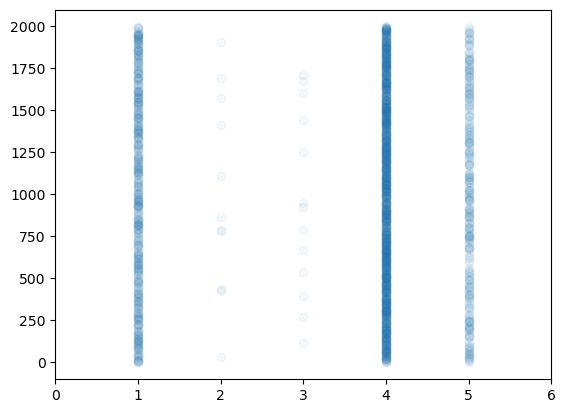

In [45]:
# surf_1_opacity = 0.5
# surf_2_opacity = 0.2
# surf_3_opacity = 1.0...
surface_opacities = np.array([0.25, 0.01, 0.01, 0.8, 1.0, 0.0])
# surface_opacities = 0.1*np.linspace(0,10,128)

num_pts = 2_000

pt_dists = np.zeros(num_pts) +1 
still_going = np.ones(num_pts)
for surf_opacity in surface_opacities:
    hit_surf_i = np.random.rand(num_pts)
    pt_dists[hit_surf_i > surf_opacity] += 1*still_going[hit_surf_i > surf_opacity]
    still_going[hit_surf_i < surf_opacity] = 0

fig, ax = p.subplots()
ax.scatter(pt_dists,np.linspace(0,num_pts-1,num_pts), alpha = 0.05)
ax.set_xlim([0,len(surface_opacities)])

In [46]:
#Reproducing the above code using TensorFlow so it can be run on many pixels at once
# Goal: given map of reflectivity chance at each point (output by network),
#       stochastically render returns from each laser beam

N_samples = 128 #128
near=0.
far=2.
z_vals = tf.linspace(near, far, N_samples)
z_vals += 0.01*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals = z_vals[:,:,:,None]
ray_pos = rays_o[...,None,:] + rays_d[...,None,:] * z_vals

#define periodic opacity pattern in x and y, randomize each in z
#  "x" and "y" axis would be the azimuthal and elevation angles of lidar sensor, "z" is radial depth
#  (this is what the output of the network is going to look like)
so = tf.tile(tf.random.uniform([1,1,100]), [10,10,1])  #surface opacity

rp_flat = tf.reshape(ray_pos, [-1,3])
dummy_opacity = ((1+(np.cos(20*rp_flat[:,1] )*np.cos(10*rp_flat[:,0]) ) [:,None])/2)[:,0]

#scale clockwise
# dummy_opacity *= np.linspace(0,1,len(dummy_opacity)) 

#sort by distance from starting point, scale opacity accordingly
dist = tf.math.sqrt(tf.math.reduce_sum(rp_flat**2, axis = 1))
in_order = tf.argsort(dist)
dummy_opacity = tf.gather(dummy_opacity, in_order)
rp_flat = tf.gather(rp_flat, in_order)

# dummy_opacity *= np.linspace(0,1,len(dummy_opacity)) #scale clockwise
# dummy_opacity = dummy_opacity**2
# dummy_opacity = 2*tf.nn.relu(dummy_opacity - 0.5)

colors = np.array([dummy_opacity, dummy_opacity, dummy_opacity])
colors = colors.T.tolist()

do = tf.reshape(dummy_opacity, [ray_pos.shape[0], ray_pos.shape[1], -1])
# print(np.shape(do))

num_pts = 128
# print(num_pts)

roll = tf.random.uniform(tf.shape(do))

hit_surfs = tf.argmax(roll < do, axis = -1)
# print("\n hit_surfs:", hit_surfs)
# print("\n hit_surfs:", np.shape(hit_surfs))

# test = tf.gather_nd(z_vals[:,:,:,0], hit_surfs[:,:,None], batch_dims = 2)
rendered_points = tf.gather_nd(ray_pos, hit_surfs[:,:,None], batch_dims = 2)
rendered_points_flat = tf.reshape(rendered_points, [-1,3])

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(rp_flat, c=colors, r = 3.5, alpha = 0.5))
disp.append(Points(rendered_points_flat, c='red', r = 5))

plt.show(disp, "Test Render-- Simulating Network Opacity Predictions ")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [47]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
# disp=[]
# for i in range(100):
#     do = tf.reshape(dummy_opacity, [ray_pos.shape[0], ray_pos.shape[1], -1])
#     # do = do [0,0,:]
#     roll = tf.random.uniform(tf.shape(do))
#     hit_surfs = tf.argmax(roll < do, axis = -1)
#     rendered_points = tf.gather_nd(ray_pos, hit_surfs[:,:,None], batch_dims = 2)
#     rendered_points_flat = tf.reshape(rendered_points, [-1,3])
#     disp.append(Points(rendered_points_flat, c='red', r = 5, alpha = 0.1))
# plt.show(disp, "Test Render-- Simulating Network Opacity Predictions ")
# ViewInteractiveWidget(plt.window)

## Attempt #2: probability of reflection up to a given point

### Modify rendering code to include randomized reflection, leave loss function intact

#### Process:
1) Pass rays and test point locations (z_vals) to the network
2) Network outputs CDF at each test point location
3) CDF is converted to discrete probability of reflectance at each test point
4) Follow similar process as Attempt #1 to render point cloud from discrete opacity map

<span style="font-size:2.5em;">
$$
P_\text{reflect} = P(r_m - \Delta) (1 - e^{\int_{r_m - \Delta}^{r_m } \alpha \text{ ds}})
$$
</span>

#### Notes:
* Getting pdf from derivative of CDF can result in numerical issues if first few samples of CDF are extremely large 

In [48]:
#create dummy cdf (this is output by the network at queried z values)
CDF = tf.constant([[[0.0, 0.5, 0.6, 1.0],
                 [0.0, 0.6, 0.6, 1.0]],
                
                [[0.0, 0.5, 0.6, 1.0],
                 [0.0, 0.6, 0.6, 1.0]]])

opacity = (CDF[:,:,1:]-CDF[:,:,:-1])/(1-CDF[:,:,:-1])
#pad the beginning with zeros to maintain the same shape beteen input and output
#  this means we are evaluting the region of length delta ending at r_m
pad = tf.zeros_like(opacity[:,:,0])[:,:,None]
opacity = tf.concat([pad, opacity], axis = -1)

#We don't need to weight by sampling density/ material thickness here
# since it's accounted for in diff of the CDF


print(opacity)

tf.Tensor(
[[[0.         0.5        0.20000005 1.        ]
  [0.         0.6        0.         1.        ]]

 [[0.         0.5        0.20000005 1.        ]
  [0.         0.6        0.         1.        ]]], shape=(2, 2, 4), dtype=float32)


In [279]:
#Try to use hit_surfs to just zero out first n points along each ray and then use weighted returns pipeline
#   -> best of both worlds-- no floaters and smooth rendering!

# print(np.shape(hit_surfs))
# print(np.shape(old_pdf))
# print(old_pdf[...,0])

# Example tensors
alpha = old_pdf[:,:,:,0]
# alpha = tf.Variable(tf.random.uniform([64, 8, 128]), dtype=tf.float32)
# hit_surfs = tf.constant([[3, 5, 7, 1, 0, 3, 2, 1] for _ in range(64)], dtype=tf.int32)

# Create a tensor of indices for the last dimension
last_dim_indices = tf.range(tf.shape(alpha)[-1], dtype=tf.int64)  # shape: [128]

# Create a mask by comparing last_dim_indices with hit_surfs
hit_surfs_expanded = hit_surfs[:, :, tf.newaxis]  # shape: [64, 8, 1]
mask = last_dim_indices[tf.newaxis, tf.newaxis, :] <= hit_surfs_expanded  # shape: [64, 8, 128]

# Invert the mask to have ones for values to keep and zeros for values to set to zero
mask = tf.cast(~mask, dtype=tf.float32)  # shape: [64, 8, 128]

# Apply the mask to the alpha tensor
alpha = alpha * mask

# Output the modified alpha tensor
# print(alpha)

# Output the modified alpha tensor
print(hit_surfs[10,0])
print(np.shape(alpha), alpha[10,0,:])

# print(hit_surfs[:4,:])
# print(3*hit_surfs[:4,:]//4)

tf.Tensor(5, shape=(), dtype=int64)
(64, 8, 128) tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.29796153 0.25199857 0.28898767 0.29511854 0.30071416 0.247913
 0.2559925  0.3033639  0.29209828 0.25994453 0.29797596 0.2520083
 0.30584577 0.26381144 0.3007688  0.28895298 0.2950925  0.25600544
 0.24786492 0.30825928 0.26756033 0.3033929  0.29801458 0.2599422
 0.31053153 0.29208398 0.25197756 0.2712154  0.3058981  0.26382136
 0.30079558 0.29513046 0.28895164 0.25600845 0.31258497 0.24785356
 0.27476883 0.26757655 0.3082496  0.30342567 0.2921207  0.2980266
 0.31458423 0.25994518 0.27823126 0.25196105 0.31054977 0.31647885
 0.27123    0.2638187  0.30590716 0.28160182 0.28894314 0.3007777
 0.24786192 0.29511297 0.2559727  0.31262204 0.3181775  0.28487578
 0.27478477 0.30829415 0.26755604 0.29805043 0.31463173 0.25197768
 0.27828896 0.31976807 0.28803182 0.25993565 0.30340478 0.29208764
 0.3105869  0.27125585 0.32123604 0.31650057 0.28165585 0.2910581
 0.2889599  0.263

In [282]:
#create dummy CDF (as would be output by the network)
# old_pdf = tf.reshape(dummy_opacity, [ray_pos.shape[0], ray_pos.shape[1], -1,1])/3
old_pdf = alpha[:,:,:,None]

CDF = 1-tf.math.cumprod((1-old_pdf[...,0]), axis = -1)
print(" \n old pdf: ", np.shape(old_pdf), " \n", old_pdf[10,0,:,0])
print(" \n CDF: ", np.shape(CDF), " \n", CDF[10,0,:])

opacity = (CDF[:,:,1:]-CDF[:,:,:-1])/(1-CDF[:,:,:-1])
pad = tf.zeros_like(opacity[:,:,0])[:,:,None]
opacity = tf.concat([pad, opacity], axis = -1)
print("\n opacity:", np.shape(opacity), " \n", opacity[10,0,:])

#do rendering similar to stratgegy #1
roll = tf.random.uniform(tf.shape(opacity))
hit_surfs = tf.argmax(roll < opacity, axis = -1)
print(hit_surfs)
rendered_points = tf.gather_nd(ray_pos, hit_surfs[:,:,None], batch_dims = 2)
rendered_points_flat = tf.reshape(rendered_points, [-1,3])

rp_flat = tf.reshape(ray_pos, [-1,3])
print("rp_flat", np.shape(rp_flat))
CDF_flat = tf.reshape(CDF, [-1])
colors = np.array([CDF_flat, CDF_flat, CDF_flat])
colors = colors.T.tolist()

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

disp.append(Points(rp_flat, c=colors, r = 3.5, alpha = 0.5))
disp.append(Points(rendered_points_flat, c = 'red'))

plt.show(disp, "Test Render-- Simulating Network Opacity Predictions ")
ViewInteractiveWidget(plt.window)

 
 old pdf:  (64, 8, 128, 1)  
 tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.29796153 0.25199857 0.28898767 0.29511854 0.30071416 0.247913
 0.2559925  0.3033639  0.29209828 0.25994453 0.29797596 0.2520083
 0.30584577 0.26381144 0.3007688  0.28895298 0.2950925  0.25600544
 0.24786492 0.30825928 0.26756033 0.3033929  0.29801458 0.2599422
 0.31053153 0.29208398 0.25197756 0.2712154  0.3058981  0.26382136
 0.30079558 0.29513046 0.28895164 0.25600845 0.31258497 0.24785356
 0.27476883 0.26757655 0.3082496  0.30342567 0.2921207  0.2980266
 0.31458423 0.25994518 0.27823126 0.25196105 0.31054977 0.31647885
 0.27123    0.2638187  0.30590716 0.28160182 0.28894314 0.3007777
 0.24786192 0.29511297 0.2559727  0.31262204 0.3181775  0.28487578
 0.27478477 0.30829415 0.26755604 0.29805043 0.31463173 0.25197768
 0.27828896 0.31976807 0.28803182 0.25993565 0.30340478 0.29208764
 0.3105869  0.27125585 0.32123604 0.31650057 0.28165585 0.2910581
 0.2889599  0.263811   0.32265845 

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

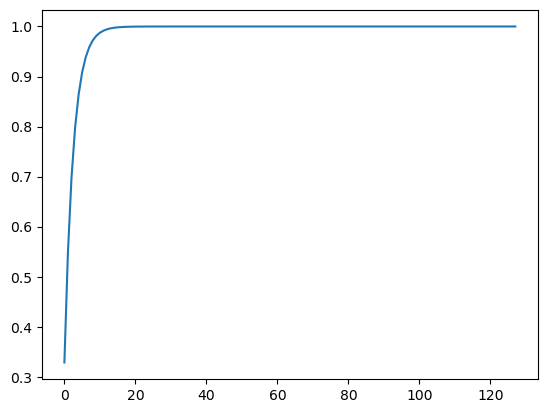

In [50]:
fig, ax = p.subplots()
ax.plot(CDF[0,0,:])

In [51]:
print(np.shape(ray_pos))
print(np.shape(dummy_opacity))
# print(np.shape(rays_o))
# print(np.shape(rays_d))
print(np.shape(z_vals))
# print(np.shape(rays_o[...,None,:]))

#Network output shape: (patch height, patch width, num z_vals, num output channels)
# ex: np.shape(raw) = (64, 8, 128, 4)

(64, 8, 128, 3)
(65536,)
(64, 8, 128, 1)


In [ ]:
# print(np.shape(z_vals[:,:,:,0]))
# print(np.shape(hit_surfs))
test = tf.gather_nd(z_vals[:,:,:,0], hit_surfs[:,:,None], batch_dims = 2)
print(np.shape(test))

In [ ]:
x = np.linspace(-5,15,10)
# x = np.random.randn(6)
softplus_x = np.log(1+np.e**x)
print(x)
print(softplus_x)
# print(tf.nn.relu(x))